<a href="https://colab.research.google.com/github/Donegas/Random-Forest-to-Reexamine-Movie-Success-Prediction-A-Profit-Analysis/blob/main/Artigo_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
#install plotly
!python -m pip install -U pip
!pip install wheel
!pip install plotly
!pip install xlsxwriter

# Standard plotly imports
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go

#Imports comuns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.api as sms
import xlsxwriter
import datetime
import random
from google.colab import files

#Warnings chatões off
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE

#Scikit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler


     |████████████████████████████████| 1.5MB 5.7MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 144 kB 4.3 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Exploring Dataset

## Reading Data

```
MOVIEID | LINK_BOXOFFICE | TITLE | TITLE_ROTTEN | ANO | REL_DATE | REL_DAY | REL_MONTH | REL_YEAR | REL_SEASON
GENRE | GENRE_ACTION | GENRE_ADVENTURE | GENRE_BIOGRAPHY | GENRE_COMEDY GENRE_CRIME | GENRE_DRAMA | GENRE_FANTASY | GENRE_HORROR | GENRE_MUSIC GENRE_SCIFI 
RUNTIME | DISTRIBUTOR | DISTRIBUTOR_ROTTEN | BIG_DISTRIBUTOR | MPAA | MPAA_G | MPAA_PG | MPAA_PG13 | MPAA_R | MPAA_NC17
DIRETOR_ROTTEN | WRITER_ROTTEN | ACTOR | CREW | SINOPSE | MOVIE_INFO | MARKETS
MAX_WEEK | FIRSTWEEK_RANK | MIN_RANK | FIRSTWEEK_THEATERS | BUDGET | DEF_BUDGET
DOMESTIC_OPENING | DEF_DOMESTIC_OPENING | FIRSTWEEK_GROSS | DEF_FIRSTWEEK_GROSS | DOMESTIC_GROSS | DEF_DOMESTIC_GROSS | INTERNATIONAL_GROSS | DEF_INTERNATIONAL_GROSS
WORLDWIDE_GROSS | DEF_WORLDWIDE_GROSS | PROFIT | IS_PROFITABLE | PROFIT_FIRSTQUARTIL | PROFIT_SECONDQUARTIL | PROFIT_50 | 
GROSS_FIRSTQUARTIL | GROSS_SECONDQUARTIL | GROSS_50 
AUD_ALL_AVG_RATING | AUD_ALL_LIKED_COUNT | AUD_ALL_NOT_LIKED_COUNT |  AUD_ALL_RATING_COUNT | AUD_ALL_REVIEW_COUNT | AUD_ALL_SCORE | AUD_ALL_SCORE_SENTIMENT |	AUD_ALL_WANT_TO_SEE	
CRITIC_ALL_AVG_SCORE | CRITIC_ALL_FRESH_COUNT | CRITIC_ALL_NUMBER_OF_REVIEWS CRITIC_ALL_ROTTEN_COUNT | CRITIC_ALL_SCORE | CRITIC_ALL_TOMATOMETER_STATE 
CRITIC_TOP_AVG_SCORE | CRITIC_TOP_FRESH_COUNT | CRITIC_TOP_NUMBER_OF_REVIEWS CRITIC_TOP_ROTTEN_COUNT | CRITIC_TOP_SCORE | CRITIC_TOP_TOMATOMETER_STATE CRITIC_TOP_TOP_REVIEWS 
CRITIC_GOOD | CRITIC_LABEL | CRITIC_25 | USER_25 | USER_GOOD | QUALITY_GOOD QUALITY_VERYGOOD | RATING_VALUE | RATING_COUNT | METACRITIC_SCORE
```


In [ ]:
data = pd.read_excel("DataA.xlsx")

In [ ]:
'''
#df = dataA.copy()

# Spliting Pre Release Feats (dropping critics and other after release stuff)
# Leaving just the useful feats so when drop null is a minor value (thinking that theres a lot of null values in criticts besides budget)

FeatsA = ['MOVIEID', 'ANO', 'REL_SEASON', 'RUNTIME', 'BIG_DISTRIBUTOR', 'MARKETS', 'FIRSTWEEK_THEATERS', 'DEF_BUDGET', 
         'GENRE_ACTION', 'GENRE_ADVENTURE', 'GENRE_BIOGRAPHY', 'GENRE_COMEDY', 'GENRE_CRIME', 'GENRE_DRAMA', 'GENRE_FANTASY', 'GENRE_HORROR', 'GENRE_MUSIC', 'GENRE_SCIFI',
         'MPAA_G' , 'MPAA_PG', 'MPAA_PG13', 'MPAA_R', 'MPAA_NC17',
         'PROFIT', 'IS_PROFITABLE'] #24 colunas (-MovieId = 23)

dataA = dataA[FeatsA]
print(dataA.isnull().sum())
print(dataA.shape)

# FIRSTWEEK_THEATERS     1945
# PROFIT                13442
# DEF_BUDGET            13442

# Dropping Null Rows
dataA.dropna(inplace=True)
print(dataA.shape) #3181, 24

# Lets take a closer look in target variable "IS_PROFITABLE"
#print("Class Values:\n", dataA['DEF_DOMESTIC_GROSS'].value_counts())
#print("Class Values:\n", dataA['DEF_DOMESTIC_OPENING'].value_counts())
'''

data.drop('Unnamed: 0', inplace=True, axis=1)
print(data.shape)
print(data.columns)
backup = data.copy()
data = data[data.ANO >= 1980]
data.reset_index(drop=True)
print(data.shape)
dataA = data.copy()

(3181, 25)
Index(['MOVIEID', 'ANO', 'REL_SEASON', 'RUNTIME', 'BIG_DISTRIBUTOR', 'MARKETS',
       'FIRSTWEEK_THEATERS', 'DEF_BUDGET', 'GENRE_ACTION', 'GENRE_ADVENTURE',
       'GENRE_BIOGRAPHY', 'GENRE_COMEDY', 'GENRE_CRIME', 'GENRE_DRAMA',
       'GENRE_FANTASY', 'GENRE_HORROR', 'GENRE_MUSIC', 'GENRE_SCIFI', 'MPAA_G',
       'MPAA_PG', 'MPAA_PG13', 'MPAA_R', 'MPAA_NC17', 'PROFIT',
       'IS_PROFITABLE'],
      dtype='object')
(3167, 25)


## Creating New Profit

In [ ]:
#dataA['PROFIT'] = dataA['DEF_DOMESTIC_GROSS'] - dataA['DEF_BUDGET']
#dataA['IS_PROFITABLE'] = 0
#dataA.loc[dataA['PROFIT'] > 0, 'IS_PROFITABLE'] = 1
#print(dataA['IS_PROFITABLE'].value_counts())
#1    1697
#0    1484

#dataA['PROFIT_DOMOP'] = dataA['DEF_DOMESTIC_OPENING'] - dataA['DEF_BUDGET']
#dataA['IS_PROFITABLE_DOMOP'] = 0
#dataA.loc[dataA['PROFIT_DOMOP'] > 0, 'IS_PROFITABLE_DOMOP'] = 1
#print(dataA['IS_PROFITABLE_DOMOP'].value_counts())
#DOMESTIC OPENING É MUITO BAIXO
#dataA.drop(['DEF_DOMESTIC_OPENING', 'PROFIT_DOMOP', 'IS_PROFITABLE_DOMOP'], inplace=True, axis=1)

## Treatments (Markets and Runtime)
### Markets
For Markets there is 115 unique values. The logic used consider in identify how many countries and if it is only domestic market opening.
```
APAC - Asian Pacific (48 countries)
LATAM - Latino America (20 countries)
EMEA - Europe, Middle East and Africa (116 countries)
LATAM + APAC = 68 countries
Latam + emea = 136 countries
apac + emea = 164 countries
 ```
### DOMESTIC: Binária
```
'Domestic', 'APAC, Domestic', 'Domestic, APAC', 'EMEA, Domestic',   'Domestic, EMEA', 'Domestic, LATAM',  'LATAM, Domestic',
```
 
### Number of Markets: Discreta
#### 1: Alone Coutries and Domestic (Alone)
``` 
'Lesser Antilles', 'Australia', 'Italy', 'Germany', 'United Kingdom', Denmark', 'Netherlands', 'France', 'Russia/CIS', 'Spain',  'Taiwan', 
'Norway', 'South  Korea', 'Greece' 'Hong Kong', 'Czech Republic', 'Puerto Rico', 'Malaysia', 'New Zealand',  'Croatia', 'Thailand', 
'United Arab Emirates', 'Mexico', 'Iceland', 'Philippines', 'Japan', 'Czech Republic/Slovakia', 'Jamaica', 'Venezuela', 'Poland', 
'Central America', 'Aruba', 'Israel', 'Switzerland', 'Finland', 'Indonesia', 'Argentina', 'Belgium', 'Ukraine', 'CuraÃ§ao', 'Portugal', 
'Romania', 'Brazil', 'Latvia', 'South Africa', 'Turkey', 'Slovenia', 'Chile', 'Slovakia', 'Jordan', 'Singapore', 'Bulgaria',  'Egypt', 
'Serbia and Montenegro',  'Lebanon', 'East Africa', 'Uruguay', 'Hungary', 'Sweden', 'China', 'India', 'Peru', 'Lithuania', 'Trinidad & Tobago', 
'Panama', 'Colombia', 'Domestic'
```
 
#### 20: 
```
'20 markets', 'LATAM', 'Domestic, LATAM',  'LATAM, Domestic'
```
#### 40: 
```
'LATAM, APAC', 'APAC, LATAM', 'LATAM, EMEA', 'EMEA, LATAM', 'APAC', 'LATAM, APAC', 'APAC, LATAM', 'APAC, EMEA', 'EMEA, APAC', 
'APAC, Domestic', 'APAC, China', 'China, APAC', 'Domestic, APAC', 'EMEA', 'APAC, EMEA', 'EMEA, APAC', 'LATAM, EMEA', 'EMEA, LATAM', 
'EMEA, Domestic', 'Domestic, EMEA', '46 markets'
```

### Runtime
About runtime, just string treatment was applied:
```
dataB['RUNTIME'] = dataB['RUNTIME'].str.replace(" hr", '*60').str.replace(' ','+').apply(eval)
```

In [ ]:
dataA['DOMESTIC'] = 0
dataA['DOMESTIC'][dataA['MARKETS'].str.contains("Domestic")] = 1

dataA['NMARKETS'] = 1
dataA['NMARKETS'][dataA['MARKETS'].str.contains("3 markets")] = 3
dataA['NMARKETS'][dataA['MARKETS'].str.contains("4 markets")] = 4
dataA['NMARKETS'][dataA['MARKETS'].str.contains("5 markets")] = 5
dataA['NMARKETS'][dataA['MARKETS'].str.contains("6 markets")] = 6
dataA['NMARKETS'][dataA['MARKETS'].str.contains("7 markets")] = 7
dataA['NMARKETS'][dataA['MARKETS'].str.contains("8 markets")] = 8
dataA['NMARKETS'][dataA['MARKETS'].str.contains("9 markets")] = 9
dataA['NMARKETS'][dataA['MARKETS'].str.contains("10 markets")] = 10
dataA['NMARKETS'][dataA['MARKETS'].str.contains("11 markets")] = 11
dataA['NMARKETS'][dataA['MARKETS'].str.contains("12 markets")] = 12
dataA['NMARKETS'][dataA['MARKETS'].str.contains("13 markets")] = 13
dataA['NMARKETS'][dataA['MARKETS'].str.contains("14 markets")] = 14
dataA['NMARKETS'][dataA['MARKETS'].str.contains("15 markets")] = 15
dataA['NMARKETS'][dataA['MARKETS'].str.contains("16 markets")] = 16
dataA['NMARKETS'][dataA['MARKETS'].str.contains("17 markets")] = 17
dataA['NMARKETS'][dataA['MARKETS'].str.contains("18 markets")] = 18
dataA['NMARKETS'][dataA['MARKETS'].str.contains("19 markets")] = 19

dataA['NMARKETS'][dataA['MARKETS'].str.contains("20 markets")] = 20
dataA['NMARKETS'][dataA['MARKETS'].str.contains("LATAM")] = 20

dataA['NMARKETS'][dataA['MARKETS'].str.contains("Domestic, LATAM")] = 21
dataA['NMARKETS'][dataA['MARKETS'].str.contains("LATAM, Domestic")] = 21
dataA['NMARKETS'][dataA['MARKETS'].str.contains("21 markets")] = 21

dataA['NMARKETS'][dataA['MARKETS'].str.contains("22 markets")] = 22
dataA['NMARKETS'][dataA['MARKETS'].str.contains("23 markets")] = 23
dataA['NMARKETS'][dataA['MARKETS'].str.contains("24 markets")] = 24
dataA['NMARKETS'][dataA['MARKETS'].str.contains("28 markets")] = 28
dataA['NMARKETS'][dataA['MARKETS'].str.contains("29 markets")] = 29
dataA['NMARKETS'][dataA['MARKETS'].str.contains("30 markets")] = 30
dataA['NMARKETS'][dataA['MARKETS'].str.contains("38 markets")] = 38

dataA['NMARKETS'][dataA['MARKETS'].str.contains("46 markets")] = 46
dataA['NMARKETS'][dataA['MARKETS'].str.contains("LATAM, APAC")] = 68
dataA['NMARKETS'][dataA['MARKETS'].str.contains("APAC, LATAM")] = 68
dataA['NMARKETS'][dataA['MARKETS'].str.contains("LATAM, EMEA")] = 136
dataA['NMARKETS'][dataA['MARKETS'].str.contains("EMEA, LATAM")] = 136
dataA['NMARKETS'][dataA['MARKETS'].str.contains("APAC")] = 48
dataA['NMARKETS'][dataA['MARKETS'].str.contains("APAC, EMEA")] = 164
dataA['NMARKETS'][dataA['MARKETS'].str.contains("EMEA, APAC")] = 164
dataA['NMARKETS'][dataA['MARKETS'].str.contains("APAC, Domestic")] = 49
dataA['NMARKETS'][dataA['MARKETS'].str.contains("APAC, China")] = 49
dataA['NMARKETS'][dataA['MARKETS'].str.contains("China, APAC")] = 49
dataA['NMARKETS'][dataA['MARKETS'].str.contains("Domestic, APAC")] = 49
dataA['NMARKETS'][dataA['MARKETS'].str.contains("EMEA")] = 116
dataA['NMARKETS'][dataA['MARKETS'].str.contains("EMEA, Domestic")] = 117
dataA['NMARKETS'][dataA['MARKETS'].str.contains("Domestic, EMEA")] = 117

dataA.drop(['MARKETS'], axis=1, inplace=True)

#Tratando Runtime:
dataA['RUNTIME'] = dataA['RUNTIME'].str.replace(" hr", '*60').str.replace(' ','+').apply(eval)

#Removing movieid
dataA.drop('MOVIEID', axis=1, inplace=True)

In [ ]:
dataA.to_excel("DataA.xlsx")

## Out: Outliers with IsolationForest

In [ ]:
dataBackup = dataA.copy()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
#help(IsolationForest)

Temp = dataBackup.copy() # because this can mess around with backup - I need profit and its not possible to log it

iso = IsolationForest(contamination=0.8)
Temp['OUT'] = iso.fit_predict(Temp)
#Temp[Temp['OUT'] == -1].index #Outliers
dataG = Temp[Temp['OUT'] == 1]
data.iloc[Temp[Temp['OUT'] == -1].index]

IndexError: ignored

## Splitting for differents datasets:
```
A --> Full;                                                                                              #3181 obs
B --> Wide: > than 600 screens; (Temp.loc[Temp['FIRSTWEEK_THEATERS'] >= 600])                            #2482 obs
C --> 1990 - 2019: 30 years of data, more observations (Temp.loc[Temp['ANO'] >= 1999])                   #3091 obs
D --> 1999 - 2019: 20 years of data, consistensy, volume of productions; (Temp.loc[Temp['ANO'] >= 1999]) #2732 obs
E --> Wide && 1990: (Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1990)])              #2430 obs
F --> Wide && 1999: (Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1999)])              #2164 obs
G --> Without Outliers (IsolationForest)                                                                 #2863 obs
H --> Wide && 2010
I --> Wide && 2015 a 2017
J --> Wide && 1990 a 1994
K --> Wide && 2000 a 2004
L --> Wide && 2010 a 2014
M --> Wide && 90 a 94 Com Year Binário
N --> Wide && 00 a 04 Com Year Binário

``` 

In [ ]:
#DataA Lines (without null already) with data columns (year mostly)
Temp = dataA.copy()

FeatsA = ['REL_SEASON', 'RUNTIME', 'BIG_DISTRIBUTOR', 'FIRSTWEEK_THEATERS', 'DEF_BUDGET', 
         'GENRE_ACTION', 'GENRE_ADVENTURE', 'GENRE_BIOGRAPHY', 'GENRE_COMEDY', 'GENRE_CRIME', 'GENRE_DRAMA', 'GENRE_FANTASY', 'GENRE_HORROR', 'GENRE_MUSIC', 'GENRE_SCIFI',
         'MPAA_G' , 'MPAA_PG', 'MPAA_PG13', 'MPAA_R', 'MPAA_NC17',
         'PROFIT', 'IS_PROFITABLE']

#Creating working sets
#dataA
dataA.drop('ANO', inplace=True, axis=1)

dataB = Temp[Temp['FIRSTWEEK_THEATERS'] >= 600][FeatsA]
dataB = dataA.loc[dataB.index] 
#dataB.drop('ANO', inplace=True, axis=1)

dataC = Temp[Temp['ANO'] >= 1990][FeatsA]
dataC = dataA.loc[dataC.index] 
#dataC.drop('ANO', inplace=True, axis=1)

dataD = Temp[Temp['ANO'] >= 1999][FeatsA]
dataD = dataA.loc[dataD.index] 
#dataD.drop('ANO', inplace=True, axis=1)

dataE = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1990)][FeatsA]
dataE = dataA.loc[dataE.index] 
#dataE.drop('ANO', inplace=True, axis=1)

dataF = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1999)][FeatsA]
dataF = dataA.loc[dataF.index] 
#dataF.drop('ANO', inplace=True, axis=1)

#dataG = dataA.loc[dataG.index]
#dataG.drop('ANO', inplace=True, axis=1)

dataH = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 2010)][FeatsA]
dataH = dataA.loc[dataH.index] 
#dataH.drop('ANO', inplace=True, axis=1)

dataI = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 2015) & (Temp['ANO'] <= 2018)][FeatsA]
dataI = dataA.loc[dataI.index] 
#dataI.drop('ANO', inplace=True, axis=1)

dataJ = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1990) & (Temp['ANO'] <= 1994)][FeatsA]
dataJ = dataA.loc[dataJ.index] 
#dataJ.drop('ANO', inplace=True, axis=1)

dataK = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 2000) & (Temp['ANO'] <= 2004)][FeatsA]
dataK = dataA.loc[dataK.index] 
#dataK.drop('ANO', inplace=True, axis=1)

dataL = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 2010) & (Temp['ANO'] <= 2014)][FeatsA]
dataL = dataA.loc[dataL.index] 
#dataL.drop('ANO', inplace=True, axis=1)

dataM = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 1990) & (Temp['ANO'] <= 1994)][FeatsA]
dataM = dataA.loc[dataM.index] 
dataM['ANO'] = Temp['ANO'].loc[dataM.index]
dataM = pd.get_dummies(dataM, columns=['ANO'])
dataM.drop('ANO_1990', inplace=True, axis=1)
#dataM.drop('ANO', inplace=True, axis=1)

dataN = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600) & (Temp['ANO'] >= 2000) & (Temp['ANO'] <= 2004)][FeatsA]
dataN = dataA.loc[dataN.index] 
dataN['ANO'] = Temp['ANO'].loc[dataN.index]
dataN = pd.get_dummies(dataN, columns=['ANO'])
dataN.drop('ANO_2003', inplace=True, axis=1)
#dataN.drop('ANO', inplace=True, axis=1)


datasets = [dataA, dataB, dataC, dataD, dataE, dataF, dataH, dataI, dataJ, dataK, dataL, dataM, dataN]
datanames = ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']

'''
for i, dataset in enumerate(datasets):
  fn = 'Data' + str(datanames[i]) + '.xlsx'
  print(fn)
  with pd.ExcelWriter(fn) as writer:  
    dataset.to_excel(writer, sheet_name='Data')
    dataset.describe().to_excel(writer, sheet_name='Describe')
  files.download(fn)
'''

"\nfor i, dataset in enumerate(datasets):\n  fn = 'Data' + str(datanames[i]) + '.xlsx'\n  print(fn)\n  with pd.ExcelWriter(fn) as writer:  \n    dataset.to_excel(writer, sheet_name='Data')\n    dataset.describe().to_excel(writer, sheet_name='Describe')\n  files.download(fn)\n"

In [ ]:
#Criando Dummy de anos para dataset B
dataANOS = Temp.loc[(Temp['FIRSTWEEK_THEATERS'] >= 600)][Temp.columns]
dataANOS = pd.get_dummies(dataANOS, columns=['ANO'])
dataANOS.drop('ANO_1980', inplace=True, axis=1)
dataANOS

,REL_SEASON,RUNTIME,BIG_DISTRIBUTOR,FIRSTWEEK_THEATERS,DEF_BUDGET,GENRE_ACTION,GENRE_ADVENTURE,GENRE_BIOGRAPHY,GENRE_COMEDY,GENRE_CRIME,GENRE_DRAMA,GENRE_FANTASY,GENRE_HORROR,GENRE_MUSIC,GENRE_SCIFI,MPAA_G,MPAA_PG,MPAA_PG13,MPAA_R,MPAA_NC17,PROFIT,IS_PROFITABLE,DOMESTIC,NMARKETS,ANO_1981,ANO_1982,ANO_1983,ANO_1984,ANO_1985,ANO_1986,ANO_1987,ANO_1988,ANO_1989,ANO_1990,ANO_1991,ANO_1992,ANO_1993,ANO_1994,ANO_1995,ANO_1996,ANO_1997,ANO_1998,ANO_1999,ANO_2000,ANO_2001,ANO_2002,ANO_2003,ANO_2004,ANO_2005,ANO_2006,ANO_2007,ANO_2008,ANO_2009,ANO_2010,ANO_2011,ANO_2012,ANO_2013,ANO_2014,ANO_2015,ANO_2016,ANO_2017,ANO_2018,ANO_2019
3,0,121,1,677,9.570267e+06,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,-7.769149e+06,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,115,1,1078,9.501742e+06,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.964397e+08,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,127,1,1397,2.850523e+07,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,2.860326e+07,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,115,1,1101,5.884146e+06,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,4.384589e+08,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,116,0,943,1.176829e+07,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,8.753368e+07,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,0,130,1,4253,2.706000e+08,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1.373040e+09,1,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3171,1,106,1,3309,1.644715e+08,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,5.041022e+07,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3172,0,100,1,1670,2.902439e+07,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,-1.739783e+07,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3176,1,86,1,2837,2.846000e+07,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,6.098478e+07,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#datasets = [dataA, dataB, dataC, dataD, dataE, dataF, dataH, dataI, dataJ, dataK, dataL, dataM, dataN, dataANOS]
#datanames = ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'ANOS']
for i, set in enumerate(datasets):
  print(datanames[i], set.shape)

A (3167, 24)
B (2475, 24)
C (3091, 24)
D (2732, 24)
E (2430, 24)
F (2164, 24)
H (990, 24)
I (383, 24)
J (120, 24)
K (567, 24)
L (536, 24)
M (120, 28)
N (567, 28)


# Classes

Many class options must be tested:

*   DataX_X1:  Binary: IS_PROFITABLE 0 or 1
*   DataX_X1s: Binary: IS_PROFITABLE 0 or 1 + SMOTE
*   DataX_X2:  Binary: GROSS >= 1.5*BUDGET
*   DataX_X3:  4 Class: PROFIT quadrants
*   DataX_X8: 6 Class Profit range - ZHANG, 2016

> for each of 6 datasets (A to F) there's 8 Class options (X1 to X6) = 48 sets to perform

## X1 & X1s

In [ ]:
# X1: Binary 
# If the movie paid itself
X1 = []
y1 = []
for i, sets in enumerate(datasets):
  print(datanames[i])
  y = sets['IS_PROFITABLE'].values
  y1.append(y)
  X = sets.copy()
  X.drop(['PROFIT', 'IS_PROFITABLE'], axis=1, inplace=True)
  X1.append(X)
  print("Class Values of", datanames[i], ":\n", np.unique(y, return_counts=True))
  print("Shape:", X.shape, "\n")


# X1s: Binary
# If the movie paid itself + SMOTE to balance the dataset classes by oversampling minority class.
# help(SMOTE)

smote = SMOTE('minority')
X1s = []
y1s = []
for i, sets in enumerate(datasets):
  print(datanames[i])
  X = sets.copy()
  y = sets['IS_PROFITABLE'].values
  X.drop('IS_PROFITABLE', axis=1, inplace=True)

  cols = X.columns
  X, y = smote.fit_sample(X, y)
  X = pd.DataFrame(X, columns = cols)
  X.drop(['PROFIT'], axis=1, inplace=True)
  X1s.append(X)
  y1s.append(y)
  print("Class Values of", datanames[i], ":\n", np.unique(y, return_counts=True))
  print("Shape:", X.shape, "\n") 

A
Class Values of A :
 (array([0, 1]), array([ 862, 2305]))
Shape: (3167, 22) 

B
Class Values of B :
 (array([0, 1]), array([ 509, 1966]))
Shape: (2475, 22) 

C
Class Values of C :
 (array([0, 1]), array([ 834, 2257]))
Shape: (3091, 22) 

D
Class Values of D :
 (array([0, 1]), array([ 687, 2045]))
Shape: (2732, 22) 

E
Class Values of E :
 (array([0, 1]), array([ 499, 1931]))
Shape: (2430, 22) 

F
Class Values of F :
 (array([0, 1]), array([ 411, 1753]))
Shape: (2164, 22) 

H
Class Values of H :
 (array([0, 1]), array([104, 886]))
Shape: (990, 22) 

I
Class Values of I :
 (array([0, 1]), array([ 45, 338]))
Shape: (383, 22) 

J
Class Values of J :
 (array([0, 1]), array([39, 81]))
Shape: (120, 22) 

K
Class Values of K :
 (array([0, 1]), array([166, 401]))
Shape: (567, 22) 

L
Class Values of L :
 (array([0, 1]), array([ 54, 482]))
Shape: (536, 22) 

M
Class Values of M :
 (array([0, 1]), array([39, 81]))
Shape: (120, 26) 

N
Class Values of N :
 (array([0, 1]), array([166, 401]))
Shap

## X2

In [ ]:
# X2: Binary: 
# An alternative for super desbalanced classes would be multiclass or another label assignament.
# This is a metric (IS_PROFITABLE) for classifying a movie when its got payed back, looking for its budget
# But could be a metric more suitable, as twice as much its budget, since the value usually is downrounded and do not consider marketing spents.
# Just taking a look about 2x budget
# GROSS >= 2*BUDGET
# PROFIT = GROSS - BUDGET
# GROSS = PROFIT + BUDGET
# PROFIT + BUDGET > = 2*BUDGET
X2 = []
y2 = []
for i, sets in enumerate(datasets):
  print(datanames[i])
  X = sets.copy()
  #X['BUD'] = np.exp(X['DEF_BUDGET'])
  X['GROSS'] = X['PROFIT'] + X['DEF_BUDGET']
  X['X2'] = 0
  X.loc[X['GROSS'] >= 2 * X['DEF_BUDGET'], 'X2'] = 1

  y = X['X2'].values
  y2.append(y)

  X.drop(['GROSS', 'X2'], axis=1, inplace=True)
  X.drop(['PROFIT', 'IS_PROFITABLE'], axis=1, inplace=True)
  X2.append(X)

  print("Class Values of", datanames[i], ":\n", np.unique(y, return_counts=True))
  print("Shape:", X.shape, "\n")

A
Class Values of A :
 (array([0, 1]), array([1513, 1654]))
Shape: (3167, 22) 

B
Class Values of B :
 (array([0, 1]), array([1056, 1419]))
Shape: (2475, 22) 

C
Class Values of C :
 (array([0, 1]), array([1475, 1616]))
Shape: (3091, 22) 

D
Class Values of D :
 (array([0, 1]), array([1279, 1453]))
Shape: (2732, 22) 

E
Class Values of E :
 (array([0, 1]), array([1040, 1390]))
Shape: (2430, 22) 

F
Class Values of F :
 (array([0, 1]), array([ 910, 1254]))
Shape: (2164, 22) 

H
Class Values of H :
 (array([0, 1]), array([315, 675]))
Shape: (990, 22) 

I
Class Values of I :
 (array([0, 1]), array([128, 255]))
Shape: (383, 22) 

J
Class Values of J :
 (array([0, 1]), array([51, 69]))
Shape: (120, 22) 

K
Class Values of K :
 (array([0, 1]), array([296, 271]))
Shape: (567, 22) 

L
Class Values of L :
 (array([0, 1]), array([172, 364]))
Shape: (536, 22) 

M
Class Values of M :
 (array([0, 1]), array([51, 69]))
Shape: (120, 26) 

N
Class Values of N :
 (array([0, 1]), array([296, 271]))
Shap

## X3

In [ ]:
# DataX_X3:  4 Class
# PROFIT quadrants
X3 = []
y3 = []

for i, sets in enumerate(datasets):
  print(datanames[i])
  X = sets.copy()
  desc = pd.DataFrame(X.describe())
  print("Min:", desc['PROFIT'][3]) #MIN
  print("25%:", desc['PROFIT'][4]) #25%
  print("50%:", desc['PROFIT'][5]) #50%
  print("75%:", desc['PROFIT'][6]) #75%
  print("Max:", desc['PROFIT'][7]) #MAX

  # I dont think that the best choice is "normalize" all movies into these quadrants, since each movie has its own logic... BUT...
  '''
  1 : <= 25%
  2 : >  25% and <= 50%
  3 : >  50% and <= 75%
  4 : >  75% 
  '''

  # Lets create more ys!!
  X['X3'] = 0
  X.loc[X['PROFIT'] <= desc['PROFIT'][4], 'X3'] = 1
  X.loc[(X['PROFIT'] > desc['PROFIT'][4]) & (X['PROFIT'] <= desc['PROFIT'][5]), 'X3'] = 2
  X.loc[(X['PROFIT'] > desc['PROFIT'][5]) & (X['PROFIT'] <= desc['PROFIT'][6]), 'X3'] = 3
  X.loc[X['PROFIT'] > desc['PROFIT'][6], 'X3'] = 4

  y = X['X3'].values
  y3.append(y)

  X.drop('X3', axis=1, inplace=True)
  X.drop(['PROFIT', 'IS_PROFITABLE'], axis=1, inplace=True)
  X3.append(X)

  print("Class Values of", datanames[i], ":\n", np.unique(y, return_counts=True))
  print("Shape:", X.shape, "\n")
  

A
Min: -144975458.05
25%: -801089.035
50%: 35248666.96
75%: 131607434.11
Max: 3626073837.54
Class Values of A :
 (array([1, 2, 3, 4]), array([792, 792, 791, 792]))
Shape: (3167, 22) 

B
Min: -144975458.05
25%: 5965732.880000001
50%: 52909445.29
75%: 156539606.33499998
Max: 3626073837.54
Class Values of B :
 (array([1, 2, 3, 4]), array([619, 619, 618, 619]))
Shape: (2475, 22) 

C
Min: -144975458.05
25%: -732057.135
50%: 36228771.31
75%: 132702959.015
Max: 3626073837.54
Class Values of C :
 (array([1, 2, 3, 4]), array([773, 773, 772, 773]))
Shape: (3091, 22) 

D
Min: -144975458.05
25%: -19328.24
50%: 40387689.445
75%: 138767558.0225
Max: 3626073837.54
Class Values of D :
 (array([1, 2, 3, 4]), array([683, 683, 683, 683]))
Shape: (2732, 22) 

E
Min: -144975458.05
25%: 6259401.9125
50%: 53298656.45
75%: 156577546.9175
Max: 3626073837.54
Class Values of E :
 (array([1, 2, 3, 4]), array([608, 607, 607, 608]))
Shape: (2430, 22) 

F
Min: -144975458.05
25%: 8202235.550000001
50%: 57298804.73999

## X8 & X8s (Zhang et al)

In [ ]:
## X8 Artigo Zhang et al, 2009 - 6 gross classes

'''
<4 ; 4 ~ 10; 10 ~ 30; 30 ~ 90; 90 ~ 200; >200  Zhang Classes
 1 ;   2   ;    3   ;    4   ;    5    ;   6

<0 ; 0 ~ 10; 10 ~ 30; 30 ~ 80; 80 ~ 200; >200

'''


X8 = []
y8 = []

for i, sets in enumerate(datasets):
  print(datanames[i])
  X = sets.copy()

  # Lets create more ys!!
  X['X8'] = 0
  X.loc[X['PROFIT'] < 0, 'X8'] = 1
  X.loc[(X['PROFIT'] >= 0) & (X['PROFIT'] < 10000000), 'X8'] = 2
  X.loc[(X['PROFIT'] >= 10000000) & (X['PROFIT'] < 30000000), 'X8'] = 3
  X.loc[(X['PROFIT'] >= 30000000) & (X['PROFIT'] < 80000000), 'X8'] = 4
  X.loc[(X['PROFIT'] >= 80000000) & (X['PROFIT'] < 200000000), 'X8'] = 5
  X.loc[X['PROFIT'] > 200000000, 'X8'] = 6

  y = X['X8'].values
  y8.append(y)

  X.drop('X8', axis=1, inplace=True)
  X.drop(['PROFIT', 'IS_PROFITABLE'], axis=1, inplace=True)
  X8.append(X)

  print("Class Values of", datanames[i], ":\n", np.unique(y, return_counts=True))
  print("Shape:", X.shape, "\n")
  

A
Class Values of A :
 (array([1, 2, 3, 4, 5, 6]), array([862, 295, 349, 559, 570, 532]))
Shape: (3167, 22) 

B
Class Values of B :
 (array([1, 2, 3, 4, 5, 6]), array([509, 176, 296, 483, 519, 492]))
Shape: (2475, 22) 

C
Class Values of C :
 (array([1, 2, 3, 4, 5, 6]), array([834, 278, 343, 551, 561, 524]))
Shape: (3091, 22) 

D
Class Values of D :
 (array([1, 2, 3, 4, 5, 6]), array([687, 243, 304, 510, 506, 482]))
Shape: (2732, 22) 

E
Class Values of E :
 (array([1, 2, 3, 4, 5, 6]), array([499, 167, 292, 476, 511, 485]))
Shape: (2430, 22) 

F
Class Values of F :
 (array([1, 2, 3, 4, 5, 6]), array([411, 149, 257, 438, 460, 449]))
Shape: (2164, 22) 

H
Class Values of H :
 (array([1, 2, 3, 4, 5, 6]), array([104,  51,  94, 209, 236, 296]))
Shape: (990, 22) 

I
Class Values of I :
 (array([1, 2, 3, 4, 5, 6]), array([ 45,  17,  41,  71,  83, 126]))
Shape: (383, 22) 

J
Class Values of J :
 (array([1, 2, 3, 4, 5, 6]), array([39,  9, 15, 15, 27, 15]))
Shape: (120, 22) 

K
Class Values of K

## Sanity Check

In [ ]:
SetsX_names = ['X1', 'X1s', 'X2', 'X3', 'X8']
SetsX = [X1, X1s, X2, X3, X8]
SetsY = [y1, y1s, y2, y3, y8]
i = 0
n = 1
for sets, Y in zip(SetsX, SetsY):
  j = 0
  for X, y  in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])
    print(X.shape)
    print(y.shape, np.unique(y, return_counts=True))
    print("\n")
    j = j+1
    n = n+1
  i = i+1

Dataset 1 : X1 --> A
(3167, 22)
(3167,) (array([0, 1]), array([ 862, 2305]))


Dataset 2 : X1 --> B
(2475, 22)
(2475,) (array([0, 1]), array([ 509, 1966]))


Dataset 3 : X1 --> C
(3091, 22)
(3091,) (array([0, 1]), array([ 834, 2257]))


Dataset 4 : X1 --> D
(2732, 22)
(2732,) (array([0, 1]), array([ 687, 2045]))


Dataset 5 : X1 --> E
(2430, 22)
(2430,) (array([0, 1]), array([ 499, 1931]))


Dataset 6 : X1 --> F
(2164, 22)
(2164,) (array([0, 1]), array([ 411, 1753]))


Dataset 7 : X1 --> H
(990, 22)
(990,) (array([0, 1]), array([104, 886]))


Dataset 8 : X1 --> I
(383, 22)
(383,) (array([0, 1]), array([ 45, 338]))


Dataset 9 : X1 --> J
(120, 22)
(120,) (array([0, 1]), array([39, 81]))


Dataset 10 : X1 --> K
(567, 22)
(567,) (array([0, 1]), array([166, 401]))


Dataset 11 : X1 --> L
(536, 22)
(536,) (array([0, 1]), array([ 54, 482]))


Dataset 12 : X1 --> M
(120, 26)
(120,) (array([0, 1]), array([39, 81]))


Dataset 13 : X1 --> N
(567, 26)
(567,) (array([0, 1]), array([166, 401]))


D

# Classifications
```
datasets = [A, B, C, D, E, F]
datanames = ['A', 'B', 'C', 'D', 'E', 'F']
SetsX_names = ['X1', 'X1s', 'X2', 'X3', 'X4', 'X4s', 'X5', 'X6']
SetsX = [X1, X1s, X2, X3, X4, X4s, X5, X6]
SetsY = [y1, y1s, y2, y3, y4, y4s, y5, y6]
```

## Grid Search

### RF

In [ ]:
### RF

param_grid = {
    #'max_depth': 'None', 
    'min_samples_leaf': [2, 5, 7, 10], 
    'min_samples_split': [2, 5, 7, 10, 20], 
    'n_estimators': [100, 500, 1000],
    'criterion': ['gini', 'entropy'],
    'random_state':[123]
    }

ResultadosGrid = pd.DataFrame()
i=0
n=0

for sets, Y in zip(SetsX, SetsY):
  j=0
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])
    X = X.to_numpy() #Transforma em Numpy pra facilitar o Split e as contas
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    X = scaling.transform(X)
    
    GridSearch = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=1)
    
    print("Chamo o Fit em: ", datetime.datetime.now())
    GridSearch.fit(X, y)
    print("Fim do Fit: ", datetime.datetime.now())
    print(SetsX_names[i], "-->", datanames[j], GridSearch.best_params_, GridSearch.best_score_)
    ResultadosGrid = ResultadosGrid.append({'Base': SetsX_names[i] + '_' + datanames[j], 'Best_Params':GridSearch.best_params_, 'Best_Score': GridSearch.best_score_}, ignore_index=True)
    print("\n")
    j = j + 1
    n = n + 1
  i = i + 1
ResultadosGrid.to_excel('GridRF5_DOMESTIC_ABCDEFGHIJKLMN.xlsx')

Dataset 0 : X1 --> A
Chamo o Fit em:  2020-09-22 17:03:13.983595
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.5min finished


Fim do Fit:  2020-09-22 17:08:47.249775
X1 --> A {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123} 0.6881510856614442


Dataset 1 : X1 --> B
Chamo o Fit em:  2020-09-22 17:08:47.263052
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.7min finished


Fim do Fit:  2020-09-22 17:13:27.413107
X1 --> B {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.7163597933667857


Dataset 2 : X1 --> C
Chamo o Fit em:  2020-09-22 17:13:27.419635
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.3min finished


Fim do Fit:  2020-09-22 17:18:47.575410
X1 --> C {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123} 0.6871595428449458


Dataset 3 : X1 --> D
Chamo o Fit em:  2020-09-22 17:18:47.583996
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.9min finished


Fim do Fit:  2020-09-22 17:23:42.552139
X1 --> D {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123} 0.6936357824392951


Dataset 4 : X1 --> E
Chamo o Fit em:  2020-09-22 17:23:42.561028
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.6min finished


Fim do Fit:  2020-09-22 17:28:21.705212
X1 --> E {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.7069958847736627


Dataset 5 : X1 --> F
Chamo o Fit em:  2020-09-22 17:28:21.716418
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.3min finished


Fim do Fit:  2020-09-22 17:32:44.397603
X1 --> F {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.7236576366824061


Dataset 6 : X1 --> G
Chamo o Fit em:  2020-09-22 17:32:44.407401
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 17:35:37.173608
X1 --> G {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123} 0.7173649865650927


Dataset 7 : X1 --> H
Chamo o Fit em:  2020-09-22 17:35:37.180675
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 17:38:51.653947
X1 --> H {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.7181818181818181


Dataset 8 : X1 --> I
Chamo o Fit em:  2020-09-22 17:38:51.659899
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 17:41:34.966015
X1 --> I {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123} 0.7259473425196851


Dataset 9 : X1 --> J
Chamo o Fit em:  2020-09-22 17:41:34.972978
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 17:44:06.498234
X1 --> J {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7333333333333334


Dataset 10 : X1 --> K
Chamo o Fit em:  2020-09-22 17:44:06.504780
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 17:46:58.486361
X1 --> K {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7054673721340388


Dataset 11 : X1 --> L
Chamo o Fit em:  2020-09-22 17:46:58.492440
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


Fim do Fit:  2020-09-22 17:49:49.891381
X1 --> L {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123} 0.7239135438244094


Dataset 12 : X1 --> M
Chamo o Fit em:  2020-09-22 17:49:49.897865
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished


Fim do Fit:  2020-09-22 17:52:21.783593
X1 --> M {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123} 0.7666666666666666


Dataset 13 : X1 --> N
Chamo o Fit em:  2020-09-22 17:52:21.789744
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 17:55:17.366661
X1 --> N {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123} 0.689594356261023


Dataset 14 : X1s --> A
Chamo o Fit em:  2020-09-22 17:55:17.376450
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.8min finished


Fim do Fit:  2020-09-22 18:01:03.232535
X1s --> A {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7130342140699152


Dataset 15 : X1s --> B
Chamo o Fit em:  2020-09-22 18:01:03.240471
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.4min finished


Fim do Fit:  2020-09-22 18:06:27.386333
X1s --> B {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.7137342322749022


Dataset 16 : X1s --> C
Chamo o Fit em:  2020-09-22 18:06:27.397999
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.6min finished


Fim do Fit:  2020-09-22 18:12:07.228881
X1s --> C {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123} 0.7123385915700645


Dataset 17 : X1s --> D
Chamo o Fit em:  2020-09-22 18:12:07.238204
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


Fim do Fit:  2020-09-22 18:17:22.731619
X1s --> D {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123} 0.7134020618556701


Dataset 18 : X1s --> E
Chamo o Fit em:  2020-09-22 18:17:22.742589
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


Fim do Fit:  2020-09-22 18:22:39.797060
X1s --> E {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.7137296532200992


Dataset 19 : X1s --> F
Chamo o Fit em:  2020-09-22 18:22:39.805449
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


Fim do Fit:  2020-09-22 18:27:39.339938
X1s --> F {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7220863295774116


Dataset 20 : X1s --> G
Chamo o Fit em:  2020-09-22 18:27:39.346664
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 18:30:37.612480
X1s --> G {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.7179189667498799


Dataset 21 : X1s --> H
Chamo o Fit em:  2020-09-22 18:30:37.620138
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.6min finished


Fim do Fit:  2020-09-22 18:34:18.374536
X1s --> H {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.7675158859518579


Dataset 22 : X1s --> I
Chamo o Fit em:  2020-09-22 18:34:18.385715
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


Fim do Fit:  2020-09-22 18:37:08.718256
X1s --> I {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.7319409980700303


Dataset 23 : X1s --> J
Chamo o Fit em:  2020-09-22 18:37:08.724809
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 18:39:42.904427
X1s --> J {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7866666666666666


Dataset 24 : X1s --> K
Chamo o Fit em:  2020-09-22 18:39:42.910887
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 18:42:39.979128
X1s --> K {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123} 0.7115384615384616


Dataset 25 : X1s --> L
Chamo o Fit em:  2020-09-22 18:42:39.985693
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.1min finished


Fim do Fit:  2020-09-22 18:45:45.428004
X1s --> L {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.7672672672672672


Dataset 26 : X1s --> M
Chamo o Fit em:  2020-09-22 18:45:45.433682
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 18:48:19.999320
X1s --> M {'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.6666666666666666


Dataset 27 : X1s --> N
Chamo o Fit em:  2020-09-22 18:48:20.005365
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 18:51:20.768894
X1s --> N {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.6490384615384616


Dataset 28 : X2 --> A
Chamo o Fit em:  2020-09-22 18:51:20.775997
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.4min finished


Fim do Fit:  2020-09-22 18:56:45.574502
X2 --> A {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123} 0.7802633684846976


Dataset 29 : X2 --> B
Chamo o Fit em:  2020-09-22 18:56:45.582941
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.6min finished


Fim do Fit:  2020-09-22 19:01:24.148274
X2 --> B {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123} 0.7860663749812585


Dataset 30 : X2 --> C
Chamo o Fit em:  2020-09-22 19:01:24.154861
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


Fim do Fit:  2020-09-22 19:06:39.255207
X2 --> C {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.7777490041716497


Dataset 31 : X2 --> D
Chamo o Fit em:  2020-09-22 19:06:39.262261
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.8min finished


Fim do Fit:  2020-09-22 19:11:29.717476
X2 --> D {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123} 0.7891710192478579


Dataset 32 : X2 --> E
Chamo o Fit em:  2020-09-22 19:11:29.728312
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.6min finished


Fim do Fit:  2020-09-22 19:16:04.837089
X2 --> E {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.7913580246913581


Dataset 33 : X2 --> F
Chamo o Fit em:  2020-09-22 19:16:04.844183
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.3min finished


Fim do Fit:  2020-09-22 19:20:24.125278
X2 --> F {'criterion': 'gini', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123} 0.7971403982618784


Dataset 34 : X2 --> G
Chamo o Fit em:  2020-09-22 19:20:24.133533
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 19:23:16.582195
X2 --> G {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123} 0.739451383352526


Dataset 35 : X2 --> H
Chamo o Fit em:  2020-09-22 19:23:16.589008
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.2min finished


Fim do Fit:  2020-09-22 19:26:31.064007
X2 --> H {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.7828282828282829


Dataset 36 : X2 --> I
Chamo o Fit em:  2020-09-22 19:26:31.071235
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 19:29:14.550443
X2 --> I {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7728838582677166


Dataset 37 : X2 --> J
Chamo o Fit em:  2020-09-22 19:29:14.556834
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 19:31:46.354420
X2 --> J {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.65


Dataset 38 : X2 --> K
Chamo o Fit em:  2020-09-22 19:31:46.360212
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 19:34:38.154682
X2 --> K {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.7936507936507936


Dataset 39 : X2 --> L
Chamo o Fit em:  2020-09-22 19:34:38.160847
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 19:37:30.743241
X2 --> L {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000, 'random_state': 123} 0.7985374427217375


Dataset 40 : X2 --> M
Chamo o Fit em:  2020-09-22 19:37:30.749946
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 19:40:02.770792
X2 --> M {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.6166666666666666


Dataset 41 : X2 --> N
Chamo o Fit em:  2020-09-22 19:40:02.776477
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 19:42:56.609188
X2 --> N {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123} 0.7901234567901234


Dataset 42 : X3 --> A
Chamo o Fit em:  2020-09-22 19:42:56.615919
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.8min finished


Fim do Fit:  2020-09-22 19:48:49.150195
X3 --> A {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123} 0.5177665546328076


Dataset 43 : X3 --> B
Chamo o Fit em:  2020-09-22 19:48:49.164604
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.1min finished


Fim do Fit:  2020-09-22 19:53:52.473779
X3 --> B {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123} 0.47785342516166346


Dataset 44 : X3 --> C
Chamo o Fit em:  2020-09-22 19:53:52.480005
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.7min finished


Fim do Fit:  2020-09-22 19:59:34.877785
X3 --> C {'criterion': 'entropy', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.5231346071147188


Dataset 45 : X3 --> D
Chamo o Fit em:  2020-09-22 19:59:34.883800
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.3min finished


Fim do Fit:  2020-09-22 20:04:56.186955
X3 --> D {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123} 0.5300141132193822


Dataset 46 : X3 --> E
Chamo o Fit em:  2020-09-22 20:04:56.197131
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.0min finished


Fim do Fit:  2020-09-22 20:09:56.197178
X3 --> E {'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.4810699588477367


Dataset 47 : X3 --> F
Chamo o Fit em:  2020-09-22 20:09:56.206519
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.7min finished


Fim do Fit:  2020-09-22 20:14:40.498290
X3 --> F {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.493989188607697


Dataset 48 : X3 --> G
Chamo o Fit em:  2020-09-22 20:14:40.508971
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 20:17:37.637400
X3 --> G {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123} 0.47876251217999827


Dataset 49 : X3 --> H
Chamo o Fit em:  2020-09-22 20:17:37.643662
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.4min finished


Fim do Fit:  2020-09-22 20:21:02.357279
X3 --> H {'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123} 0.48888888888888893


Dataset 50 : X3 --> I
Chamo o Fit em:  2020-09-22 20:21:02.363754
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


Fim do Fit:  2020-09-22 20:23:52.481482
X3 --> I {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123} 0.4909161745406824


Dataset 51 : X3 --> J
Chamo o Fit em:  2020-09-22 20:23:52.487314
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.5min finished


Fim do Fit:  2020-09-22 20:26:26.363337
X3 --> J {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123} 0.4916666666666667


Dataset 52 : X3 --> K
Chamo o Fit em:  2020-09-22 20:26:26.370941
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 20:29:23.105674
X3 --> K {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.5044091710758377


Dataset 53 : X3 --> L
Chamo o Fit em:  2020-09-22 20:29:23.111232
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


Fim do Fit:  2020-09-22 20:32:20.352147
X3 --> L {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123} 0.43284581424057916


Dataset 54 : X3 --> M
Chamo o Fit em:  2020-09-22 20:32:20.358733
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 20:34:56.788391
X3 --> M {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.47500000000000003


Dataset 55 : X3 --> N
Chamo o Fit em:  2020-09-22 20:34:56.794329
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


Fim do Fit:  2020-09-22 20:37:57.312854
X3 --> N {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123} 0.49559082892416223


Dataset 56 : X8 --> A
Chamo o Fit em:  2020-09-22 20:37:57.320328
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.3min finished


Fim do Fit:  2020-09-22 20:44:13.004896
X8 --> A {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.4935544964700443


Dataset 57 : X8 --> B
Chamo o Fit em:  2020-09-22 20:44:13.013508
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.3min finished


Fim do Fit:  2020-09-22 20:49:33.805001
X8 --> B {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123} 0.4617226184704235


Dataset 58 : X8 --> C
Chamo o Fit em:  2020-09-22 20:49:33.815839
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.1min finished


Fim do Fit:  2020-09-22 20:55:38.844078
X8 --> C {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.4969241538205594


Dataset 59 : X8 --> D
Chamo o Fit em:  2020-09-22 20:55:38.851858
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.6min finished


Fim do Fit:  2020-09-22 21:01:12.582476
X8 --> D {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.4981668898244091


Dataset 60 : X8 --> E
Chamo o Fit em:  2020-09-22 21:01:12.588468
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.2min finished


Fim do Fit:  2020-09-22 21:06:29.130822
X8 --> E {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123} 0.4625514403292181


Dataset 61 : X8 --> F
Chamo o Fit em:  2020-09-22 21:06:29.140123
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.9min finished


Fim do Fit:  2020-09-22 21:11:24.733577
X8 --> F {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123} 0.46026089751717053


Dataset 62 : X8 --> G
Chamo o Fit em:  2020-09-22 21:11:24.740232
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


Fim do Fit:  2020-09-22 21:14:23.801871
X8 --> G {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123} 0.4992396728378658


Dataset 63 : X8 --> H
Chamo o Fit em:  2020-09-22 21:14:23.810349
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.5min finished


Fim do Fit:  2020-09-22 21:17:54.101917
X8 --> H {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.4323232323232323


Dataset 64 : X8 --> I
Chamo o Fit em:  2020-09-22 21:17:54.108259
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.8min finished


Fim do Fit:  2020-09-22 21:20:43.175535
X8 --> I {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123} 0.451669127296588


Dataset 65 : X8 --> J
Chamo o Fit em:  2020-09-22 21:20:43.182853
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished


Fim do Fit:  2020-09-22 21:23:17.250286
X8 --> J {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000, 'random_state': 123} 0.45


Dataset 66 : X8 --> K
Chamo o Fit em:  2020-09-22 21:23:17.257231
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 21:26:16.825354
X8 --> K {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123} 0.5132275132275131


Dataset 67 : X8 --> L
Chamo o Fit em:  2020-09-22 21:26:16.830328
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 21:29:18.578516
X8 --> L {'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.42537610110267193


Dataset 68 : X8 --> M
Chamo o Fit em:  2020-09-22 21:29:18.584732
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-22 21:31:52.395939
X8 --> M {'criterion': 'entropy', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123} 0.45


Dataset 69 : X8 --> N
Chamo o Fit em:  2020-09-22 21:31:52.401725
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


Fim do Fit:  2020-09-22 21:34:55.084898
X8 --> N {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123} 0.5167548500881834




### MLP

In [ ]:
## Grid MLP

param_grid = {
    'hidden_layer_sizes': [(100), (30, 20, 30), (10, 10, 10, 10)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['adaptive'],
    'momentum': [0.4, 0.6],
    'learning_rate_init': [0.001, 0.01],
    'max_iter':[500, 1000, 3000],
    'n_iter_no_change': [25, 50],
    'early_stopping': [True]
}

ResultadosGrid = pd.DataFrame()
i=0
n=0

for sets, Y in zip(SetsX, SetsY):
  j=0
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])
    X = X.to_numpy() #Transforma em Numpy pra facilitar o Split e as contas
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    X = scaling.transform(X)
    
    GridSearch = GridSearchCV(MLPClassifier(), param_grid = param_grid, cv=3, n_jobs=-1, scoring="accuracy", verbose=1)
    
    print("Chamo o Fit em: ", datetime.datetime.now())
    GridSearch.fit(X, y)
    print("Fim do Fit: ", datetime.datetime.now())
    print(SetsX_names[i], "-->", datanames[j], GridSearch.best_params_, GridSearch.best_score_)
    ResultadosGrid = ResultadosGrid.append({'Base': SetsX_names[i] + '_' + datanames[j], 'Best_Params':GridSearch.best_params_, 'Best_Score': GridSearch.best_score_}, ignore_index=True)
    print("\n")
    j = j + 1
    n = n + 1
  i = i + 1
ResultadosGrid.to_excel('GridMLP_3.xlsx')

Dataset 0 : X1 --> I
Chamo o Fit em:  2020-09-19 02:59:37.770666
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   57.3s finished


Fim do Fit:  2020-09-19 03:00:35.296058
X1 --> I {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'} 0.8929625984251969


Dataset 1 : X1 --> J
Chamo o Fit em:  2020-09-19 03:00:35.308777
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   32.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:01:08.201998
X1 --> J {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.7166666666666668


Dataset 2 : X1 --> K
Chamo o Fit em:  2020-09-19 03:01:08.210861
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:02:18.460162
X1 --> K {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'} 0.72663139329806


Dataset 3 : X1 --> L
Chamo o Fit em:  2020-09-19 03:02:18.469862
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   58.2s finished


Fim do Fit:  2020-09-19 03:03:16.919197
X1 --> L {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.9029878852551629


Dataset 4 : X1s --> I
Chamo o Fit em:  2020-09-19 03:03:16.928143
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.7min finished


Fim do Fit:  2020-09-19 03:05:58.488543
X1s --> I {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.9231006227466404


Dataset 5 : X1s --> J
Chamo o Fit em:  2020-09-19 03:05:58.498342
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   41.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:06:40.140585
X1s --> J {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.7777777777777778


Dataset 6 : X1s --> K
Chamo o Fit em:  2020-09-19 03:06:40.149966
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.6min finished


Fim do Fit:  2020-09-19 03:09:19.906537
X1s --> K {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.7893910596828592


Dataset 7 : X1s --> L
Chamo o Fit em:  2020-09-19 03:09:19.916455
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  3.3min finished


Fim do Fit:  2020-09-19 03:12:41.423582
X1s --> L {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'} 0.9419225634178905


Dataset 8 : X2 --> I
Chamo o Fit em:  2020-09-19 03:12:41.435578
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.2min finished


Fim do Fit:  2020-09-19 03:13:52.322696
X2 --> I {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'} 0.7048064304461942


Dataset 9 : X2 --> J
Chamo o Fit em:  2020-09-19 03:13:52.332644
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   34.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:14:27.126827
X2 --> J {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'} 0.6583333333333333


Dataset 10 : X2 --> K
Chamo o Fit em:  2020-09-19 03:14:27.135390
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.5min finished


Fim do Fit:  2020-09-19 03:15:57.031781
X2 --> K {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'} 0.6772486772486772


Dataset 11 : X2 --> L
Chamo o Fit em:  2020-09-19 03:15:57.044152
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:17:08.326041
X2 --> L {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'} 0.6884062519615842


Dataset 12 : X3 --> I
Chamo o Fit em:  2020-09-19 03:17:08.336314
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.5min finished


Fim do Fit:  2020-09-19 03:18:37.182225
X3 --> I {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'} 0.5430405183727034


Dataset 13 : X3 --> J
Chamo o Fit em:  2020-09-19 03:18:37.191715
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   36.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:19:13.813506
X3 --> J {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'} 0.4083333333333334


Dataset 14 : X3 --> K
Chamo o Fit em:  2020-09-19 03:19:13.821505
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.6min finished


Fim do Fit:  2020-09-19 03:20:50.533704
X3 --> K {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.43915343915343913


Dataset 15 : X3 --> L
Chamo o Fit em:  2020-09-19 03:20:50.542312
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:22:23.893965
X3 --> L {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'} 0.47949490511162723


Dataset 16 : X8 --> I
Chamo o Fit em:  2020-09-19 03:22:23.904510
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.4min finished


Fim do Fit:  2020-09-19 03:23:48.573359
X8 --> I {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.451669127296588


Dataset 17 : X8 --> J
Chamo o Fit em:  2020-09-19 03:23:48.580616
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   36.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fim do Fit:  2020-09-19 03:24:25.041804
X8 --> J {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'} 0.39166666666666666


Dataset 18 : X8 --> K
Chamo o Fit em:  2020-09-19 03:24:25.050827
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.5min finished


Fim do Fit:  2020-09-19 03:25:55.940571
X8 --> K {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.3703703703703704


Dataset 19 : X8 --> L
Chamo o Fit em:  2020-09-19 03:25:55.948344
Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.6min finished


Fim do Fit:  2020-09-19 03:27:34.740082
X8 --> L {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'} 0.42910049588851923




### SVM

In [ ]:
## Grid SVM

param_grid = {'C': [1, 50, 100, 200],  
              'gamma':['scale'], 
              'coef0': [0.01, 0.1, 1], 
              'degree': [3, 4, 5], 
              'kernel': ['poly', 'rbf', 'linear'],
              'class_weight': ['balanced']}

ResultadosGrid = pd.DataFrame()
i=0
n=0

for sets, Y in zip(SetsX, SetsY):
  j=0
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])
    X = X.to_numpy() #Transforma em Numpy pra facilitar o Split e as contas
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    X = scaling.transform(X)
    
    GridSearch = GridSearchCV(svm.SVC(), param_grid = param_grid, cv=3, n_jobs=1, scoring="accuracy", verbose=1)
    print("Chamo o Fit em: ", datetime.datetime.now())
    GridSearch.fit(X, y)
    print("Fim do Fit: ", datetime.datetime.now())
    print(SetsX_names[i], "-->", datanames[j], GridSearch.best_params_, GridSearch.best_score_)
    ResultadosGrid = ResultadosGrid.append({'Base': SetsX_names[i] + '_' + datanames[j], 'Best_Params':GridSearch.best_params_, 'Best_Score': GridSearch.best_score_}, ignore_index=True)
    print("\n")
    j = j + 1
    n = n + 1
  i = i + 1
ResultadosGrid.to_excel('GridSVM_3.xlsx')

Dataset 0 : X1 --> I
Chamo o Fit em:  2020-09-19 04:00:14.874901
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   24.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:00:39.569102
X1 --> I {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'} 0.8485892388451445


Dataset 1 : X1 --> J
Chamo o Fit em:  2020-09-19 04:00:39.585971
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:00:51.150961
X1 --> J {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.7083333333333334


Dataset 2 : X1 --> K
Chamo o Fit em:  2020-09-19 04:00:51.159307
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   36.2s finished


Fim do Fit:  2020-09-19 04:01:28.023325
X1 --> K {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.6913580246913581


Dataset 3 : X1 --> L
Chamo o Fit em:  2020-09-19 04:01:28.035302
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   26.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:01:54.627561
X1 --> L {'C': 100, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'} 0.8507103550729186


Dataset 4 : X1s --> I
Chamo o Fit em:  2020-09-19 04:01:54.636839
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   37.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:02:31.967629
X1s --> I {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'} 0.940832513929859


Dataset 5 : X1s --> J
Chamo o Fit em:  2020-09-19 04:02:31.975483
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:02:36.428779
X1s --> J {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.7901234567901234


Dataset 6 : X1s --> K
Chamo o Fit em:  2020-09-19 04:02:36.437222
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:03:17.764639
X1s --> K {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'} 0.775690834218421


Dataset 7 : X1s --> L
Chamo o Fit em:  2020-09-19 04:03:17.774470
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:04:34.978454
X1s --> L {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'} 0.9398392703959546


Dataset 8 : X2 --> I
Chamo o Fit em:  2020-09-19 04:04:34.988067
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   25.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:05:00.415269
X2 --> I {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'} 0.6735564304461942


Dataset 9 : X2 --> J
Chamo o Fit em:  2020-09-19 04:05:00.423374
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:05:06.047113
X2 --> J {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.6583333333333333


Dataset 10 : X2 --> K
Chamo o Fit em:  2020-09-19 04:05:06.054498
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   34.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:05:40.574963
X2 --> K {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.7072310405643739


Dataset 11 : X2 --> L
Chamo o Fit em:  2020-09-19 04:05:40.583909
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   30.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:06:10.922804
X2 --> L {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.6436402820496725


Dataset 12 : X3 --> I
Chamo o Fit em:  2020-09-19 04:06:10.930728
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   53.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:07:04.269681
X3 --> I {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.5509965551181102


Dataset 13 : X3 --> J
Chamo o Fit em:  2020-09-19 04:07:04.276960
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:07:07.342121
X3 --> J {'C': 50, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'} 0.35833333333333334


Dataset 14 : X3 --> K
Chamo o Fit em:  2020-09-19 04:07:07.350329
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  1.4min finished


Fim do Fit:  2020-09-19 04:08:29.964055
X3 --> K {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.48677248677248675


Dataset 15 : X3 --> L
Chamo o Fit em:  2020-09-19 04:08:29.977604
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  1.3min finished


Fim do Fit:  2020-09-19 04:09:52.652040
X3 --> L {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.49265582825936854


Dataset 16 : X8 --> I
Chamo o Fit em:  2020-09-19 04:09:52.661287
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   38.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:10:30.802257
X8 --> I {'C': 1, 'class_weight': 'balanced', 'coef0': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'} 0.4280470800524934


Dataset 17 : X8 --> J
Chamo o Fit em:  2020-09-19 04:10:30.809438
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:10:32.436017
X8 --> J {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.3083333333333333


Dataset 18 : X8 --> K
Chamo o Fit em:  2020-09-19 04:10:32.444795
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  1.6min finished


Fim do Fit:  2020-09-19 04:12:08.941157
X8 --> K {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'} 0.3474426807760141


Dataset 19 : X8 --> L
Chamo o Fit em:  2020-09-19 04:12:08.950846
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fim do Fit:  2020-09-19 04:13:40.518067
X8 --> L {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.3787583955809428




[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  1.5min finished


## Indutores

### RF

In [ ]:
dataANOS
dataANOS.rename(columns={"ANO_1981": "YEAR_1981", 
                         "ANO_1982": "YEAR_1982",
                         "ANO_1983": "YEAR_1983",
                         "ANO_1984": "YEAR_1984",
                         "ANO_1985": "YEAR_1985",
                         "ANO_1986": "YEAR_1986",
                         "ANO_1987": "YEAR_1987",
                         "ANO_1988": "YEAR_1988",
                         "ANO_1989": "YEAR_1989",
                         "ANO_1990": "YEAR_1990",
                         "ANO_1991": "YEAR_1991",
                         "ANO_1992": "YEAR_1992",
                         "ANO_1993": "YEAR_1993",
                         "ANO_1994": "YEAR_1994",
                         "ANO_1995": "YEAR_1995",
                         "ANO_1996": "YEAR_1996",
                         "ANO_1997": "YEAR_1997",
                         "ANO_1998": "YEAR_1998",
                         "ANO_1999": "YEAR_1999",
                         "ANO_2000": "YEAR_2000",
                         "ANO_2001": "YEAR_2001",
                         "ANO_2002": "YEAR_2002",
                         "ANO_2003": "YEAR_2003",
                         "ANO_2004": "YEAR_2004",
                         "ANO_2005": "YEAR_2005",
                         "ANO_2006": "YEAR_2006",
                         "ANO_2007": "YEAR_2007",
                         "ANO_2008": "YEAR_2008",
                         "ANO_2009": "YEAR_2009",
                         "ANO_2010": "YEAR_2010",
                         "ANO_2011": "YEAR_2011",
                         "ANO_2012": "YEAR_2012",
                         "ANO_2013": "YEAR_2013",
                         "ANO_2014": "YEAR_2014",
                         "ANO_2015": "YEAR_2015",
                         "ANO_2016": "YEAR_2016",
                         "ANO_2017": "YEAR_2017",
                         "ANO_2018": "YEAR_2018",
                         "ANO_2019": "YEAR_2019"}, inplace=True)
dataANOS

,REL_SEASON,RUNTIME,BIG_DISTRIBUTOR,FIRSTWEEK_THEATERS,DEF_BUDGET,GENRE_ACTION,GENRE_ADVENTURE,GENRE_BIOGRAPHY,GENRE_COMEDY,GENRE_CRIME,GENRE_DRAMA,GENRE_FANTASY,GENRE_HORROR,GENRE_MUSIC,GENRE_SCIFI,MPAA_G,MPAA_PG,MPAA_PG13,MPAA_R,MPAA_NC17,PROFIT,IS_PROFITABLE,DOMESTIC,NMARKETS,YEAR_1981,YEAR_1982,YEAR_1983,YEAR_1984,YEAR_1985,YEAR_1986,YEAR_1987,YEAR_1988,YEAR_1989,YEAR_1990,YEAR_1991,YEAR_1992,YEAR_1993,YEAR_1994,YEAR_1995,YEAR_1996,YEAR_1997,YEAR_1998,YEAR_1999,YEAR_2000,YEAR_2001,YEAR_2002,YEAR_2003,YEAR_2004,YEAR_2005,YEAR_2006,YEAR_2007,YEAR_2008,YEAR_2009,YEAR_2010,YEAR_2011,YEAR_2012,YEAR_2013,YEAR_2014,YEAR_2015,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019
3,0,121,1,677,9.570267e+06,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,-7.769149e+06,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,115,1,1078,9.501742e+06,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.964397e+08,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,127,1,1397,2.850523e+07,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,2.860326e+07,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,115,1,1101,5.884146e+06,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,4.384589e+08,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,116,0,943,1.176829e+07,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,8.753368e+07,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3170,0,130,1,4253,2.706000e+08,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1.373040e+09,1,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3171,1,106,1,3309,1.644715e+08,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,5.041022e+07,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3172,0,100,1,1670,2.902439e+07,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,-1.739783e+07,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3176,1,86,1,2837,2.846000e+07,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,6.098478e+07,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#SetsX[1][6]
len(SetsY[1][6])

1772

Dataset 0 : X1 --> H
      REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
0       1.000000  116.000000         1.000000  ...        0.0  0.000000    1.000000
1       1.000000  115.000000         1.000000  ...        0.0  0.000000    1.000000
2       0.000000   94.000000         1.000000  ...        0.0  0.000000    1.000000
3       0.000000   98.000000         1.000000  ...        0.0  0.000000  116.000000
4       0.000000  108.000000         1.000000  ...        0.0  0.000000  116.000000
...          ...         ...              ...  ...        ...       ...         ...
1767    0.964373   90.964373         0.035627  ...        0.0  1.000000    1.000000
1768    0.000000   89.970140         1.000000  ...        0.0  0.000000  116.000000
1769    0.000000  102.548919         1.000000  ...        0.0  0.193615   23.459318
1770    0.000000  106.682106         1.000000  ...        0.0  0.240301    1.000000
1771    0.000000   95.277578         1.000000  ...     

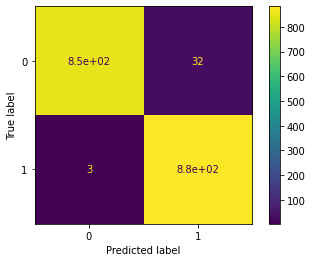

No handles with labels found to put in legend.


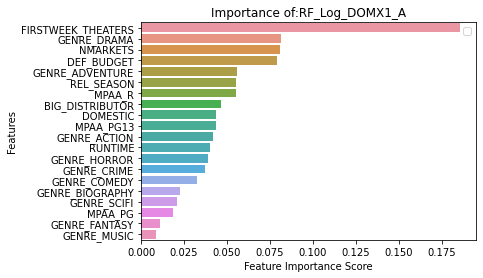

array([1, 1, 1, ..., 0, 0, 0])

<Figure size 432x288 with 0 Axes>

In [ ]:
param = [{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123},
{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 123}
]
# bootstrap=True, class_weight=None, criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100

params = [{'criterion': 'gini', 'min_samples_leaf':2, 'min_samples_split':5, 'n_estimators':100, 'random_state':1}]

Resultados = pd.DataFrame()

testeX = SetsX[0][0]
testeY = SetsY[1][6]
#teste.drop(['PROFIT', 'IS_PROFITABLE'], axis=1, inplace=True)
SetsX = [[testeX]]
SetsY = [[testeY]]
name = ['H']

#Para cada Conjunto em SetsX, SetsY
#Para cada Conjunto em datasets
i=0
n=0
for sets, Y in zip(SetsX, SetsY):
  j=0
  text = []
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", name[j])

    Acur = []; Conf = []; loss = []; 
    Prec = []; Recall = []; FBeta = []; Support = []

    DiscFeats = ['FIRSTWEEK_THEATERS', 'DEF_BUDGET', 'RUNTIME', 'NMARKETS']
    print(X)
    for feat in DiscFeats:
      X[feat] = np.log(X[feat]+1)

    cols = X.columns
    X = X.to_numpy()
    #y = classes[i]
    #scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    #X = scaling.transform(X)

    #Roda StratifiedKFold que separa em K pastas e mantém a estratificação (gera apenas os índices)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123) 
    cv_n=1
    for train_index, test_index in cv.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      model = RandomForestClassifier(random_state=1, max_depth=None, n_estimators=params[n]['n_estimators'], 
                                   criterion=params[n]['criterion'], min_samples_leaf=params[n]['min_samples_leaf'],
                                   min_samples_split=params[n]['min_samples_split'])
      RF_model = model.fit(X_train, y_train)
      pred = RF_model.predict(X_test)

      Acur.append(metrics.accuracy_score(y_test, pred))
      Conf.append(metrics.confusion_matrix(y_test, pred))
      Eita = precision_recall_fscore_support(y_test, pred)
      Prec.append(Eita[0]) # 0 precisionfloat (if average is not None) or array of float, shape = [n_unique_labels]
      Recall.append(Eita[1]) # 1 recallfloat (if average is not None) or array of float, , shape = [n_unique_labels]
      FBeta.append(Eita[2]) # 2 fbeta_scorefloat (if average is not None) or array of float, shape = [n_unique_labels]
      Support.append(Eita[3]) # 3 supportNone (if average is not None) or array of int, shape = [n_unique_labels]   
      
      print(cv_n, metrics.accuracy_score(y_test, pred))
      cv_n = cv_n+1
    
    #print(model)
    print(np.mean(Acur))
    plot_confusion_matrix(model, X, y)  # doctest: +SKIP
    plt.show()
    
    Resultados = Resultados.append({'Dataset': str(SetsX_names[i]) + "_" + str(datanames[j]) ,
                       'Params':model, 'Acuracia': np.mean(Acur)}, ignore_index=True)
    
    feature_imp = pd.Series(RF_model.feature_importances_,index=cols).sort_values(ascending=False)

    # Creating a bar plot
    sns.barplot(x=feature_imp[0:20], y=feature_imp.index[0:20])
    # Add labels to your graph
    title = "RF_Log_DOM"+ str(SetsX_names[i]) + "_" + str(datanames[j])
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Importance of:" + str(title))
    plt.legend()
    plt.show()
    plt.savefig(str(title) + ".png")
    #files.download(str(title) + ".png")

    j = j+1
    n = n+1

  i = i+1
#Resultados.to_excel('RF_DOM_Log_X1238_A-N.xlsx')
#files.download('RF_DOM_Log_X1238_A-N.xlsx')

RF_model.predict(X)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(testeX)
print(classification_report(testeY, y_pred))
print(confusion_matrix(testeY, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       886
           1       0.97      1.00      0.98       886

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772

[[854  32]
 [  3 883]]


In [ ]:
feature_imp[0:60]

FIRSTWEEK_THEATERS    0.189803
DOMESTIC              0.087027
REL_SEASON            0.074269
DEF_BUDGET            0.072722
GENRE_DRAMA           0.063252
GENRE_COMEDY          0.060166
MPAA_R                0.043697
NMARKETS              0.040832
MPAA_PG13             0.037964
GENRE_ADVENTURE       0.036722
GENRE_HORROR          0.036677
GENRE_CRIME           0.034041
RUNTIME               0.028230
GENRE_ACTION          0.028113
GENRE_FANTASY         0.020201
MPAA_PG               0.018242
ANO_1999              0.017635
BIG_DISTRIBUTOR       0.015495
GENRE_SCIFI           0.012304
ANO_2000              0.009656
ANO_2001              0.009297
GENRE_BIOGRAPHY       0.006138
ANO_2004              0.004700
ANO_2002              0.004430
GENRE_MUSIC           0.004407
ANO_2005              0.004262
ANO_2014              0.003465
ANO_1998              0.003133
ANO_2008              0.002981
ANO_1995              0.002767
ANO_2009              0.002571
ANO_2003              0.002531
ANO_2010

In [ ]:
for i in range(len(SetsX_names)):
  for j in range(len(datanames)):
    title = "RF_Log_DOM" + str(SetsX_names[i]) + "_" + str(datanames[j] + ".png")
    #print(title)                     
    files.download(str(title))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
len(SetsX_names)

5

### MLP 

Dataset 0 : X1 --> A
1 0.7304075235109718
2 0.7295597484276729
3 0.720125786163522
4 0.6949685534591195
5 0.6792452830188679
6 0.7295597484276729
7 0.7578616352201258
8 0.7264150943396226
9 0.7264150943396226
10 0.6823899371069182
0.7176948404014116


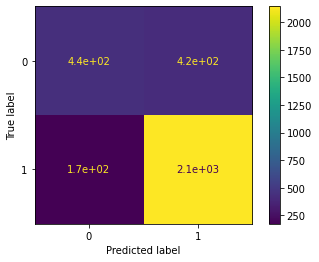

Dataset 1 : X1 --> B
1 0.8152610441767069
2 0.7791164658634538
3 0.7782258064516129
4 0.7701612903225806
5 0.8064516129032258
6 0.75
7 0.7903225806451613
8 0.7903225806451613
9 0.7903225806451613
10 0.8346774193548387
0.7904861381007902


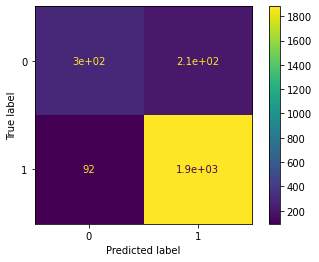

Dataset 2 : X1 --> C
1 0.7096774193548387
2 0.7346278317152104
3 0.6763754045307443
4 0.7249190938511327
5 0.6957928802588996
6 0.7216828478964401
7 0.7540453074433657
8 0.7055016181229773
9 0.7087378640776699
10 0.6763754045307443
0.7107735671782024


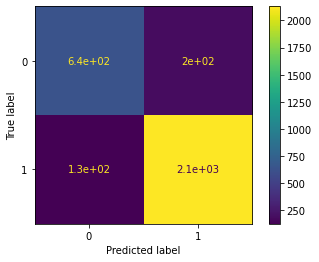

Dataset 3 : X1 --> D
1 0.718978102189781
2 0.7043795620437956
3 0.7435897435897436
4 0.7106227106227107
5 0.7142857142857143
6 0.7326007326007326
7 0.7545787545787546
8 0.717948717948718
9 0.717948717948718
10 0.7216117216117216
0.723654447742039


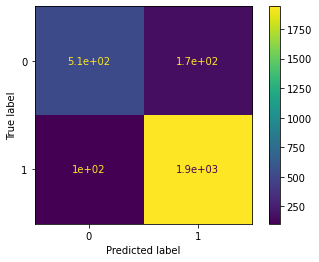

Dataset 4 : X1 --> E
1 0.7695473251028807
2 0.7777777777777778
3 0.7942386831275721
4 0.7489711934156379
5 0.7695473251028807
6 0.7818930041152263
7 0.7448559670781894
8 0.7407407407407407
9 0.7942386831275721
10 0.7530864197530864
0.7674897119341565


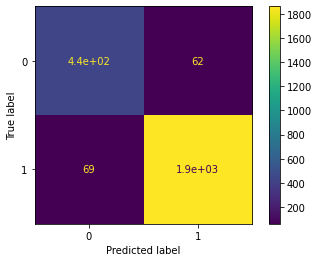

Dataset 5 : X1 --> F
1 0.7695852534562212
2 0.8064516129032258
3 0.7741935483870968
4 0.783410138248848
5 0.7546296296296297
6 0.7777777777777778
7 0.7962962962962963
8 0.7962962962962963
9 0.8009259259259259
10 0.7824074074074074
0.7841973886328725


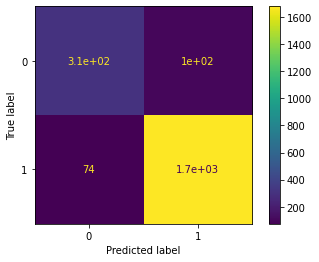

Dataset 6 : X1 --> G
1 0.71875
2 0.734375
3 0.8125
4 0.734375
5 0.859375
6 0.78125
7 0.84375
8 0.7619047619047619
9 0.8095238095238095
10 0.7619047619047619
0.7817708333333333


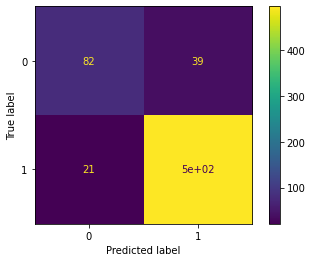

Dataset 7 : X1 --> H
1 0.8585858585858586
2 0.898989898989899
3 0.8383838383838383
4 0.8686868686868687
5 0.8888888888888888
6 0.9191919191919192
7 0.8585858585858586
8 0.8585858585858586
9 0.8787878787878788
10 0.8686868686868687
0.8737373737373737


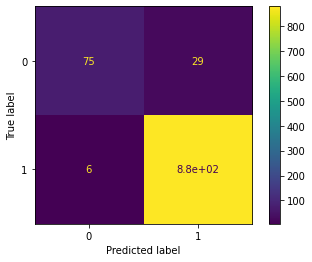

Dataset 8 : X1 --> I
1 0.8974358974358975
2 0.7948717948717948
3 0.8205128205128205
4 0.8421052631578947
5 0.7894736842105263
6 0.8421052631578947
7 0.868421052631579
8 0.7894736842105263
9 0.868421052631579
10 0.868421052631579
0.8381241565452091


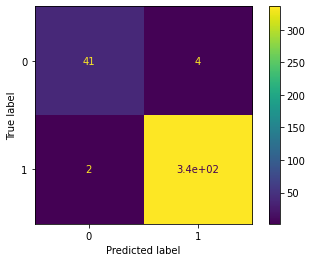

Dataset 9 : X1 --> J
1 0.6666666666666666
2 0.5833333333333334
3 0.6666666666666666
4 0.8333333333333334
5 0.6666666666666666
6 0.75
7 0.5833333333333334
8 0.75
9 0.5833333333333334
10 0.8333333333333334
0.6916666666666667


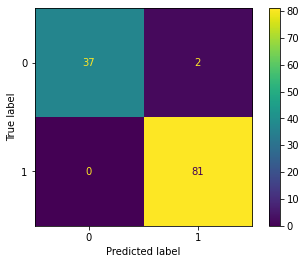

Dataset 10 : X1 --> K
1 0.7017543859649122
2 0.7719298245614035
3 0.7017543859649122
4 0.8070175438596491
5 0.8421052631578947
6 0.6842105263157895
7 0.7192982456140351
8 0.5892857142857143
9 0.7678571428571429
10 0.5892857142857143
0.7174498746867168


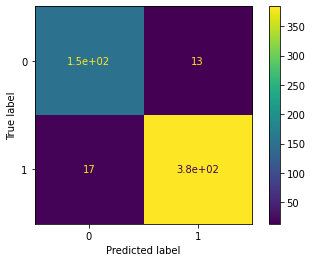

Dataset 11 : X1 --> L
1 0.8703703703703703
2 0.8703703703703703
3 0.8888888888888888
4 0.8333333333333334
5 0.8333333333333334
6 0.9074074074074074
7 0.8679245283018868
8 0.8679245283018868
9 0.8679245283018868
10 0.9056603773584906
0.8713137665967855


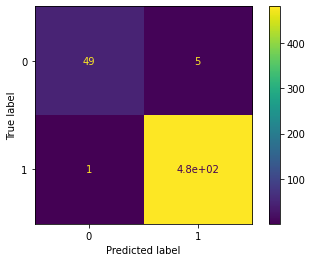

Dataset 12 : X1s --> A
1 0.8211206896551724
2 0.8125
3 0.8038793103448276
4 0.8060344827586207
5 0.7537796976241901
6 0.8012958963282938
7 0.7926565874730022
8 0.8207343412526998
9 0.7796976241900648
10 0.7818574514038877
0.7973556081030759


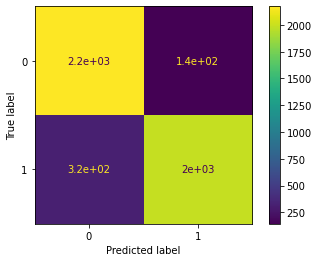

Dataset 13 : X1s --> B
1 0.9012658227848102
2 0.8759493670886076
3 0.8455696202531645
4 0.8784810126582279
5 0.8759493670886076
6 0.8734177215189873
7 0.8629441624365483
8 0.8451776649746193
9 0.8096446700507615
10 0.8730964467005076
0.8641495855554842


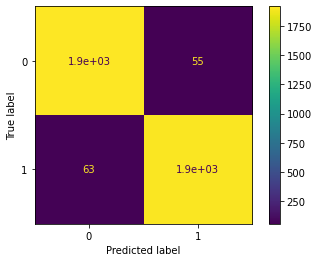

Dataset 14 : X1s --> C
1 0.7986725663716814
2 0.834070796460177
3 0.7676991150442478
4 0.7964601769911505
5 0.7960088691796009
6 0.8070953436807096
7 0.7849223946784922
8 0.7960088691796009
9 0.7982261640798226
10 0.7804878048780488
0.7959652100543531


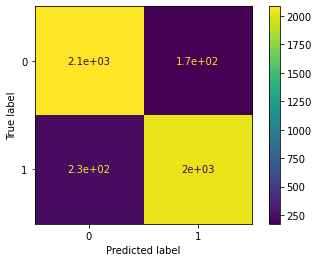

Dataset 15 : X1s --> D
1 0.8068459657701712
2 0.8215158924205379
3 0.8190709046454768
4 0.8141809290953546
5 0.784841075794621
6 0.8117359413202934
7 0.8190709046454768
8 0.8288508557457213
9 0.8141809290953546
10 0.8068459657701712
0.812713936430318


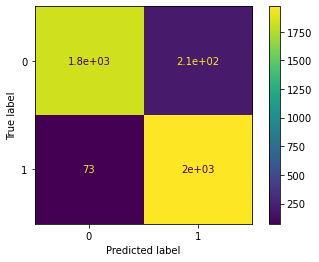

Dataset 16 : X1s --> E
1 0.8837209302325582
2 0.8863049095607235
3 0.9015544041450777
4 0.8652849740932642
5 0.8678756476683938
6 0.8497409326424871
7 0.8756476683937824
8 0.8601036269430051
9 0.883419689119171
10 0.8886010362694301
0.8762253819067892


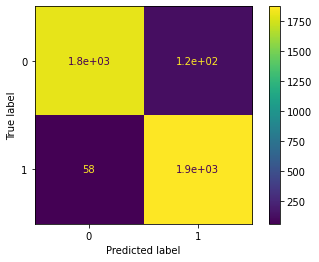

Dataset 17 : X1s --> F
1 0.905982905982906
2 0.886039886039886
3 0.8518518518518519
4 0.8803418803418803
5 0.8603988603988604
6 0.8888888888888888
7 0.9228571428571428
8 0.9057142857142857
9 0.8885714285714286
10 0.8942857142857142
0.8884932844932845


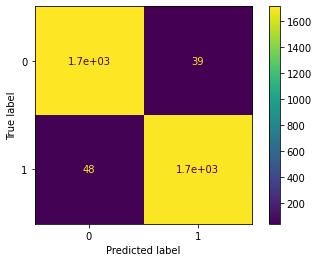

Dataset 18 : X1s --> G
1 0.875
2 0.8173076923076923
3 0.8737864077669902
4 0.7475728155339806
5 0.8446601941747572
6 0.8543689320388349
7 0.8640776699029126
8 0.7961165048543689
9 0.8446601941747572
10 0.8446601941747572
0.8362210604929052


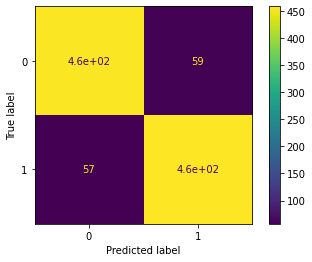

Dataset 19 : X1s --> H
1 0.9269662921348315
2 0.9606741573033708
3 0.9096045197740112
4 0.96045197740113
5 0.9548022598870056
6 0.9717514124293786
7 0.9661016949152542
8 0.903954802259887
9 0.9491525423728814
10 0.9378531073446328
0.9441312765822383


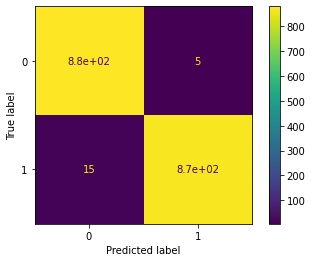

Dataset 20 : X1s --> I
1 0.9558823529411765
2 0.9411764705882353
3 0.9411764705882353
4 0.9117647058823529
5 0.9264705882352942
6 0.9558823529411765
7 0.9402985074626866
8 0.9552238805970149
9 0.9701492537313433
10 0.9701492537313433
0.9468173836698858


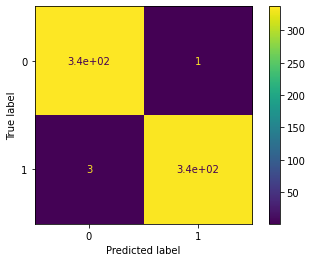

Dataset 21 : X1s --> J
1 0.8823529411764706
2 0.7647058823529411
3 0.8125
4 0.8125
5 0.9375
6 0.6875
7 0.75
8 0.8125
9 0.75
10 0.8125
0.8022058823529411


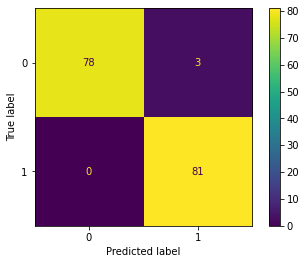

Dataset 22 : X1s --> K
1 0.8024691358024691
2 0.8518518518518519
3 0.75
4 0.85
5 0.8875
6 0.8125
7 0.8625
8 0.6875
9 0.875
10 0.7625
0.814182098765432


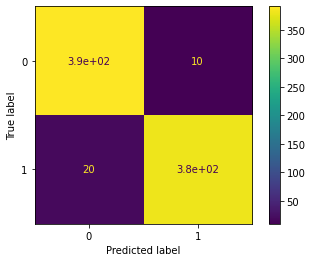

Dataset 23 : X1s --> L
1 0.9690721649484536
2 0.979381443298969
3 0.9690721649484536
4 0.9484536082474226
5 0.9166666666666666
6 0.9791666666666666
7 0.9375
8 0.9270833333333334
9 0.96875
10 0.9479166666666666
0.9543062714776631


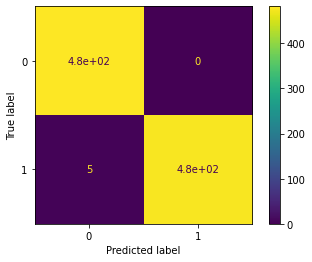

Dataset 24 : X2 --> A
1 0.6363636363636364
2 0.6352201257861635
3 0.6352201257861635
4 0.6635220125786163
5 0.6572327044025157
6 0.6352201257861635
7 0.6698113207547169
8 0.610062893081761
9 0.6163522012578616
10 0.660377358490566
0.6419382504288165


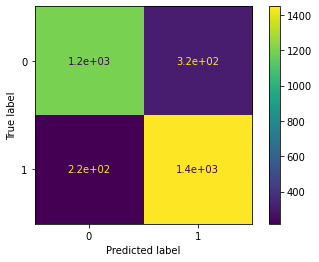

Dataset 25 : X2 --> B
1 0.6706827309236948
2 0.678714859437751
3 0.7338709677419355
4 0.6814516129032258
5 0.6854838709677419
6 0.7056451612903226
7 0.6774193548387096
8 0.6935483870967742
9 0.6653225806451613
10 0.6491935483870968
0.6841333074232413


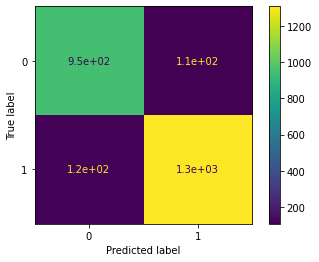

Dataset 26 : X2 --> C
1 0.5709677419354838
2 0.6213592233009708
3 0.6375404530744336
4 0.656957928802589
5 0.5922330097087378
6 0.6148867313915858
7 0.6440129449838188
8 0.627831715210356
9 0.5954692556634305
10 0.6019417475728155
0.6163200751644221


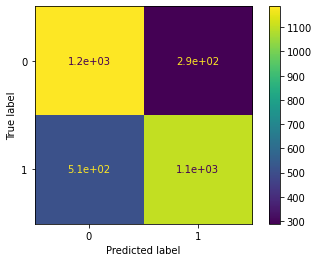

Dataset 27 : X2 --> D
1 0.6204379562043796
2 0.6058394160583942
3 0.652014652014652
4 0.6043956043956044
5 0.5604395604395604
6 0.6227106227106227
7 0.6336996336996337
8 0.5457875457875457
9 0.5641025641025641
10 0.5824175824175825
0.5991845137830538


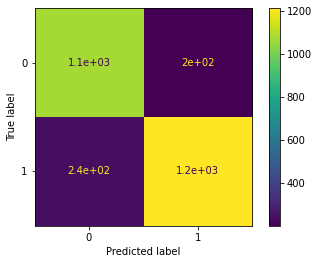

Dataset 28 : X2 --> E
1 0.6625514403292181
2 0.6460905349794238
3 0.691358024691358
4 0.654320987654321
5 0.7078189300411523
6 0.6748971193415638
7 0.6625514403292181
8 0.7489711934156379
9 0.720164609053498
10 0.6625514403292181
0.6831275720164609


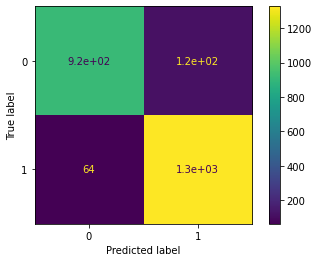

Dataset 29 : X2 --> F
1 0.6774193548387096
2 0.6451612903225806
3 0.7096774193548387
4 0.7188940092165899
5 0.6574074074074074
6 0.6620370370370371
7 0.7175925925925926
8 0.6759259259259259
9 0.6527777777777778
10 0.6574074074074074
0.6774300221880868


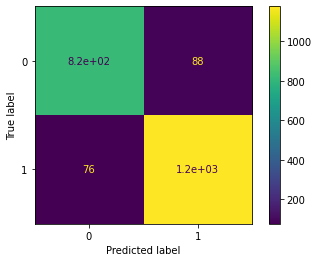

Dataset 30 : X2 --> G
1 0.546875
2 0.609375
3 0.5625
4 0.640625
5 0.546875
6 0.546875
7 0.640625
8 0.5714285714285714
9 0.6031746031746031
10 0.5714285714285714
0.5839781746031745


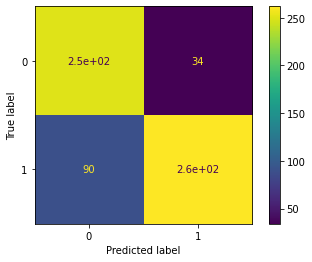

Dataset 31 : X2 --> H
1 0.6464646464646465
2 0.5959595959595959
3 0.6464646464646465
4 0.6161616161616161
5 0.6666666666666666
6 0.6363636363636364
7 0.7171717171717171
8 0.6767676767676768
9 0.7272727272727273
10 0.7474747474747475
0.6676767676767678


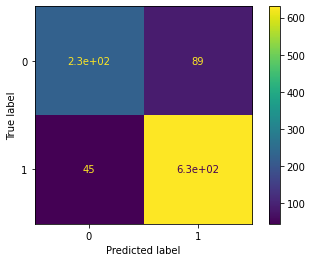

Dataset 32 : X2 --> I
1 0.7435897435897436
2 0.5384615384615384
3 0.6410256410256411
4 0.7105263157894737
5 0.6578947368421053
6 0.7631578947368421
7 0.7368421052631579
8 0.6578947368421053
9 0.7368421052631579
10 0.7105263157894737
0.6896761133603239


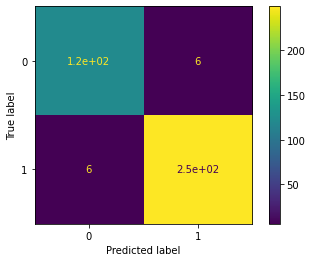

Dataset 33 : X2 --> J
1 0.6666666666666666
2 0.5833333333333334
3 0.75
4 0.6666666666666666
5 0.6666666666666666
6 0.75
7 0.5
8 0.75
9 0.5833333333333334
10 0.4166666666666667
0.6333333333333333


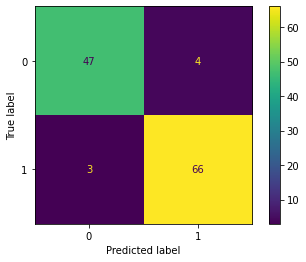

Dataset 34 : X2 --> K
1 0.7192982456140351
2 0.7719298245614035
3 0.6491228070175439
4 0.7192982456140351
5 0.7192982456140351
6 0.6140350877192983
7 0.7368421052631579
8 0.625
9 0.6964285714285714
10 0.6607142857142857
0.6911967418546365


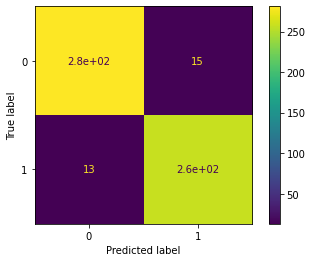

Dataset 35 : X2 --> L
1 0.6481481481481481
2 0.7407407407407407
3 0.6851851851851852
4 0.6666666666666666
5 0.7407407407407407
6 0.6851851851851852
7 0.6226415094339622
8 0.6415094339622641
9 0.6415094339622641
10 0.660377358490566
0.6732704402515723


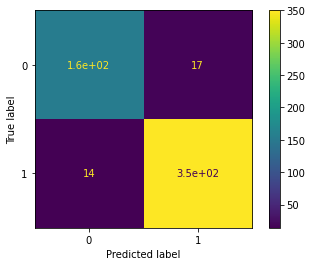

Dataset 36 : X3 --> A
1 0.44200626959247646
2 0.4276729559748428
3 0.36792452830188677
4 0.4088050314465409
5 0.41823899371069184
6 0.4276729559748428
7 0.39308176100628933
8 0.4371069182389937
9 0.39308176100628933
10 0.42138364779874216
0.4136974823051596


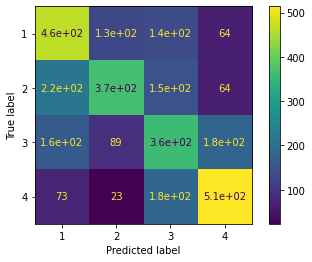

Dataset 37 : X3 --> B
1 0.42971887550200805
2 0.5180722891566265
3 0.4435483870967742
4 0.4959677419354839
5 0.45161290322580644
6 0.4637096774193548
7 0.5080645161290323
8 0.46774193548387094
9 0.5040322580645161
10 0.4596774193548387
0.47421460033683116


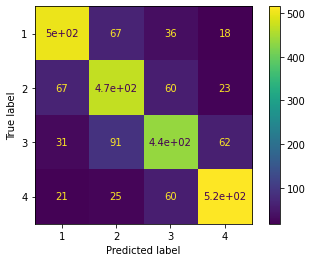

Dataset 38 : X3 --> C
1 0.4
2 0.42394822006472493
3 0.46601941747572817
4 0.4077669902912621
5 0.44336569579288027
6 0.4627831715210356
7 0.4110032362459547
8 0.39158576051779936
9 0.43042071197411
10 0.3656957928802589
0.4202588996763755


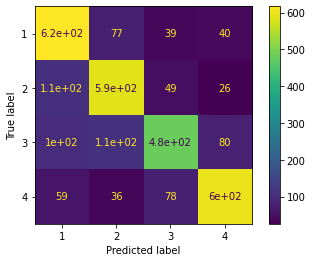

Dataset 39 : X3 --> D
1 0.41605839416058393
2 0.4197080291970803
3 0.4432234432234432
4 0.43223443223443225
5 0.4358974358974359
6 0.4175824175824176
7 0.38095238095238093
8 0.38461538461538464
9 0.42124542124542125
10 0.4249084249084249
0.41764257640170044


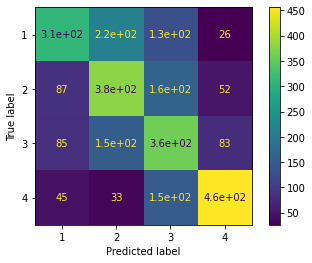

Dataset 40 : X3 --> E
1 0.5020576131687243
2 0.5308641975308642
3 0.49382716049382713
4 0.48148148148148145
5 0.48148148148148145
6 0.4691358024691358
7 0.5061728395061729
8 0.4403292181069959
9 0.5061728395061729
10 0.5102880658436214
0.4921810699588477


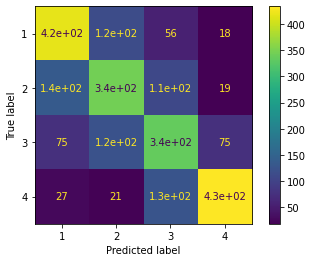

Dataset 41 : X3 --> F
1 0.511520737327189
2 0.511520737327189
3 0.48847926267281105
4 0.47465437788018433
5 0.4861111111111111
6 0.47685185185185186
7 0.5046296296296297
8 0.4583333333333333
9 0.46296296296296297
10 0.48148148148148145
0.4856545485577744


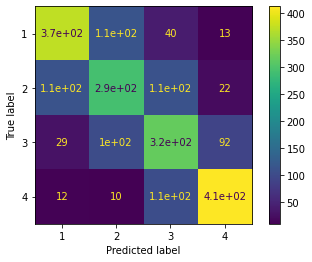

Dataset 42 : X3 --> G
1 0.4375
2 0.375
3 0.46875
4 0.359375
5 0.375
6 0.4375
7 0.390625
8 0.4126984126984127
9 0.4603174603174603
10 0.3492063492063492
0.4065972222222222


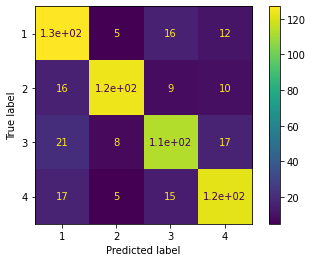

Dataset 43 : X3 --> H
1 0.40404040404040403
2 0.3939393939393939
3 0.46464646464646464
4 0.45454545454545453
5 0.45454545454545453
6 0.4444444444444444
7 0.45454545454545453
8 0.40404040404040403
9 0.43434343434343436
10 0.3838383838383838
0.42929292929292934


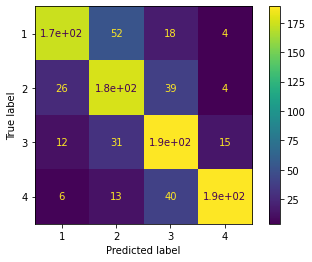

Dataset 44 : X3 --> I
1 0.46153846153846156
2 0.38461538461538464
3 0.5128205128205128
4 0.631578947368421
5 0.5526315789473685
6 0.5789473684210527
7 0.39473684210526316
8 0.5789473684210527
9 0.47368421052631576
10 0.5
0.5069500674763833


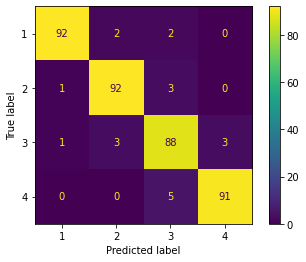

Dataset 45 : X3 --> J
1 0.4166666666666667
2 0.5
3 0.4166666666666667
4 0.5833333333333334
5 0.25
6 0.3333333333333333
7 0.4166666666666667
8 0.3333333333333333
9 0.4166666666666667
10 0.08333333333333333
0.375


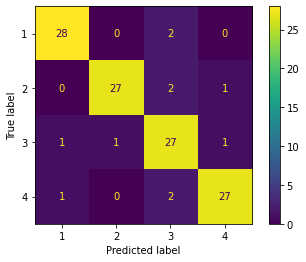

Dataset 46 : X3 --> K
1 0.3684210526315789
2 0.42105263157894735
3 0.38596491228070173
4 0.3684210526315789
5 0.38596491228070173
6 0.42105263157894735
7 0.47368421052631576
8 0.39285714285714285
9 0.48214285714285715
10 0.42857142857142855
0.41281328320802


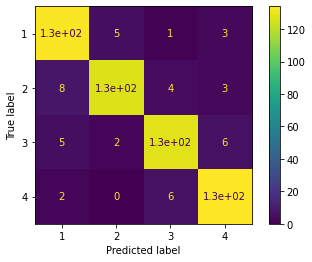

Dataset 47 : X3 --> L
1 0.3888888888888889
2 0.4074074074074074
3 0.42592592592592593
4 0.4444444444444444
5 0.48148148148148145
6 0.42592592592592593
7 0.4528301886792453
8 0.4528301886792453
9 0.39622641509433965
10 0.32075471698113206
0.41967155835080366


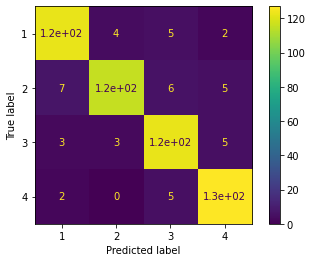

Dataset 48 : X8 --> A
1 0.322884012539185
2 0.389937106918239
3 0.3522012578616352
4 0.3238993710691824
5 0.389937106918239
6 0.389937106918239
7 0.39622641509433965
8 0.36163522012578614
9 0.3805031446540881
10 0.36163522012578614
0.3668795962224719


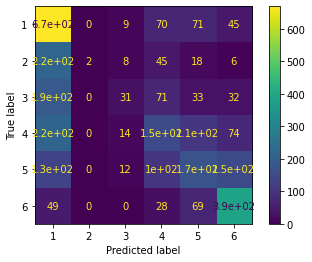

Dataset 49 : X8 --> B
1 0.3373493975903614
2 0.357429718875502
3 0.3185483870967742
4 0.3870967741935484
5 0.3346774193548387
6 0.3709677419354839
7 0.3588709677419355
8 0.3790322580645161
9 0.3346774193548387
10 0.3225806451612903
0.3501230729369089


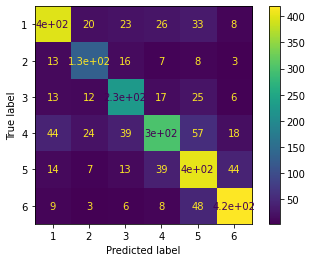

Dataset 50 : X8 --> C
1 0.34838709677419355
2 0.3559870550161812
3 0.4174757281553398
4 0.37540453074433655
5 0.40129449838187703
6 0.36893203883495146
7 0.3656957928802589
8 0.3818770226537217
9 0.4110032362459547
10 0.35275080906148865
0.3778807808748304


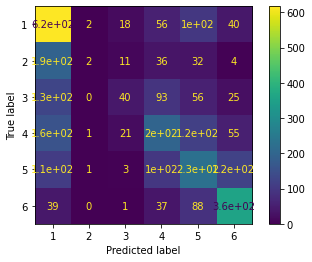

Dataset 51 : X8 --> D
1 0.40875912408759124
2 0.35766423357664234
3 0.37362637362637363
4 0.32967032967032966
5 0.3516483516483517
6 0.37362637362637363
7 0.36996336996337
8 0.336996336996337
9 0.3443223443223443
10 0.34065934065934067
0.3586936178177055


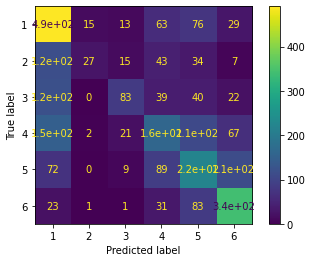

Dataset 52 : X8 --> E
1 0.3991769547325103
2 0.3786008230452675
3 0.3662551440329218
4 0.4074074074074074
5 0.345679012345679
6 0.411522633744856
7 0.3786008230452675
8 0.36213991769547327
9 0.3868312757201646
10 0.3868312757201646
0.3823045267489712


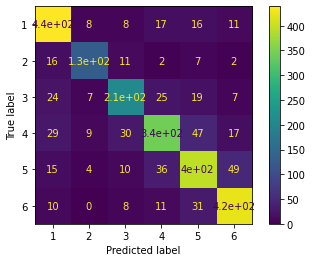

Dataset 53 : X8 --> F
1 0.3456221198156682
2 0.41013824884792627
3 0.4055299539170507
4 0.3456221198156682
5 0.4351851851851852
6 0.4583333333333333
7 0.3425925925925926
8 0.4027777777777778
9 0.4537037037037037
10 0.39814814814814814
0.39976531831370543


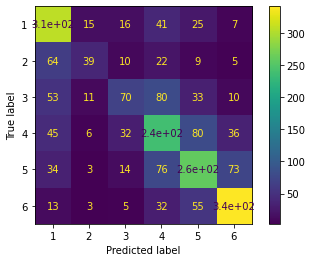

Dataset 54 : X8 --> G
1 0.28125
2 0.28125
3 0.234375
4 0.203125
5 0.25
6 0.40625
7 0.3125
8 0.25396825396825395
9 0.25396825396825395
10 0.3333333333333333
0.28100198412698413


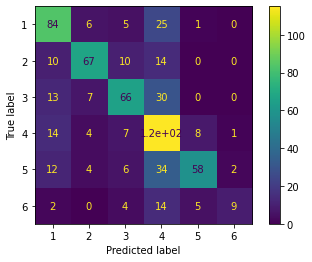

Dataset 55 : X8 --> H
1 0.37373737373737376
2 0.37373737373737376
3 0.37373737373737376
4 0.4444444444444444
5 0.48484848484848486
6 0.3838383838383838
7 0.3939393939393939
8 0.30303030303030304
9 0.41414141414141414
10 0.42424242424242425
0.39696969696969703


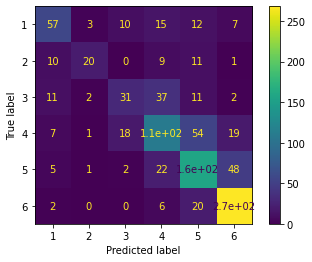

Dataset 56 : X8 --> I
1 0.20512820512820512
2 0.3333333333333333
3 0.41025641025641024
4 0.3157894736842105
5 0.3157894736842105
6 0.2631578947368421
7 0.34210526315789475
8 0.4473684210526316
9 0.2894736842105263
10 0.2894736842105263
0.3211875843454791


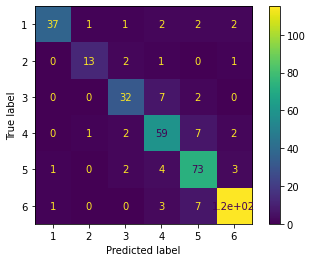

Dataset 57 : X8 --> J
1 0.16666666666666666
2 0.3333333333333333
3 0.25
4 0.3333333333333333
5 0.08333333333333333
6 0.16666666666666666
7 0.25
8 0.16666666666666666
9 0.5
10 0.3333333333333333
0.25833333333333336


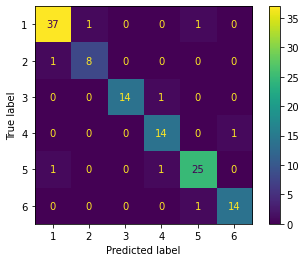

Dataset 58 : X8 --> K
1 0.3157894736842105
2 0.3684210526315789
3 0.42105263157894735
4 0.2631578947368421
5 0.3157894736842105
6 0.3333333333333333
7 0.2807017543859649
8 0.32142857142857145
9 0.375
10 0.26785714285714285
0.3262531328320802


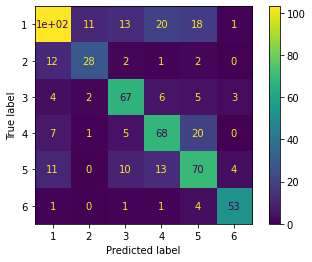

Dataset 59 : X8 --> L
1 0.3148148148148148
2 0.3333333333333333
3 0.3888888888888889
4 0.3333333333333333
5 0.35185185185185186
6 0.37037037037037035
7 0.33962264150943394
8 0.3018867924528302
9 0.41509433962264153
10 0.2641509433962264
0.34133473095737243


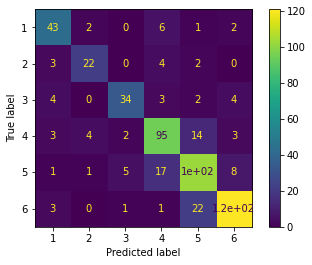

In [ ]:
params = [{'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},

          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},

          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},

          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},

          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (30, 20, 30), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 25, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 3000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.4, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 500, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'},
          {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (10, 10, 10, 10), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'momentum': 0.6, 'n_iter_no_change': 50, 'solver': 'adam'}          
]

Resultados = pd.DataFrame()
i=0
n=0
for sets, Y in zip(SetsX, SetsY):
  j=0
  text = []
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])

    Acur = []; Conf = []; loss = []; 
    Prec = []; Recall = []; FBeta = []; Support = []

    #DiscFeats = ['FIRSTWEEK_THEATERS', 'DEF_BUDGET', 'RUNTIME', 'NMARKETS']
    #for feat in DiscFeats:
    #  X[feat] = np.log(X[feat]+1)

    cols = X.columns
    X = X.to_numpy()
      
    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    X = scaling.transform(X)

    #Roda StratifiedKFold que separa em K pastas e mantém a estratificação (gera apenas os índices)
    sample = StratifiedKFold(n_splits=10, shuffle=True, random_state=123) 
    cv_n = 1
    for train_index, test_index in sample.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      
      model = MLPClassifier(random_state=123, max_iter=params[n]['max_iter'],activation=params[n]['activation'],alpha=params[n]['alpha'], 
                            hidden_layer_sizes=params[n]['hidden_layer_sizes'], learning_rate=params[n]['learning_rate'], solver=params[n]['solver'],
                            learning_rate_init=params[n]['learning_rate_init'], momentum=params[n]['momentum'], n_iter_no_change=params[n]['n_iter_no_change'])
      model.fit(X_train, y_train)
      pred = model.predict(X_test)

      #Rev.append(metrics.recall_score(y_test, pred))
      #Prec.append(metrics.precision_score(y_test, pred))
      Acur.append(metrics.accuracy_score(y_test, pred))
      Conf.append(metrics.confusion_matrix(y_test, pred))
      Eita = precision_recall_fscore_support(y_test, pred)
      Prec.append(Eita[0]) # 0 precisionfloat (if average is not None) or array of float, shape = [n_unique_labels]
      Recall.append(Eita[1]) # 1 recallfloat (if average is not None) or array of float, , shape = [n_unique_labels]
      FBeta.append(Eita[2]) # 2 fbeta_scorefloat (if average is not None) or array of float, shape = [n_unique_labels]
      Support.append(Eita[3]) # 3 supportNone (if average is not None) or array of int, shape = [n_unique_labels]   
      
      print(cv_n, metrics.accuracy_score(y_test, pred))
      cv_n = cv_n+1
    
    #print(model)
    print(np.mean(Acur))
    plot_confusion_matrix(model, X, y)  # doctest: +SKIP
    plt.show()
    
    #ICAcur = sms.DescrStatsW(Acur).tconfint_mean()
    #ICPrec = sms.DescrStatsW(Prec).tconfint_mean()
    #ICRev = sms.DescrStatsW(Rev).tconfint_mean()

    Resultados = Resultados.append({'Dataset': str(SetsX_names[i]) + "_" + str(datanames[j]) ,
                       'Params':model, 'Acuracia': np.mean(Acur), 'Precision': np.mean(Prec, axis=0), 
                       'Recall': np.mean(Recall, axis=0), 'FBeta': np.mean(FBeta, axis=0),  
                       'Support': np.mean(Support, axis=0)}, ignore_index=True)
    #print(Resultados)
    j = j+1
    n = n+1
  i = i+1
Resultados.to_excel('MLP6_MinMax_X1238_ABCDEFGHIJKL.xlsx')

### SVM

Dataset 0 : X1 --> A
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3181.000000  3181.000000  ...  3181.000000  3181.000000
mean      0.414335     1.737759  ...     0.596982     0.800510
std       0.492684     0.028485  ...     0.490581     0.483479
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     0.869742
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6990595611285266
2 0.7515723270440252
3 0.7138364779874213
4 0.6886792452830188
5 0.6761006289308176
6 0.7232704402515723
7 0.7075471698113207
8 0.7044025157232704
9 0.7075471698113207
10 0.6918238993710691
0.7063839435342363


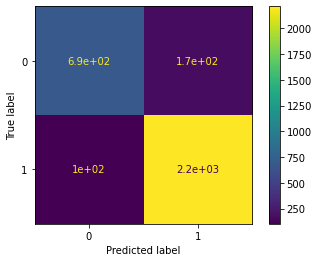

Dataset 1 : X1 --> B
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2482.000000  2482.000000  ...  2482.000000  2482.000000
mean      0.415391     1.737255  ...     0.553989     0.852515
std       0.492889     0.027631  ...     0.497177     0.510040
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.397363
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.7751004016064257
2 0.7309236947791165
3 0.7580645161290323
4 0.7661290322580645
5 0.7379032258064516
6 0.7782258064516129
7 0.7379032258064516
8 0.7419354838709677
9 0.7137096774193549
10 0.7580645161290323
0.749795958025651


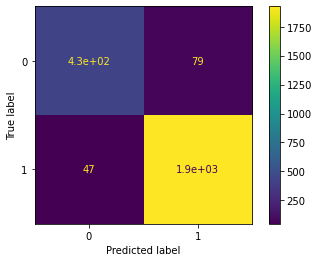

Dataset 2 : X1 --> C
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3091.000000  3091.000000  ...  3091.000000  3091.000000
mean      0.411194     1.737601  ...     0.585247     0.808485
std       0.492130     0.028367  ...     0.492759     0.488172
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.026672
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6741935483870968
2 0.7249190938511327
3 0.7184466019417476
4 0.7378640776699029
5 0.6990291262135923
6 0.7087378640776699
7 0.7249190938511327
8 0.7152103559870551
9 0.7022653721682848
10 0.686084142394822
0.7091669276542436


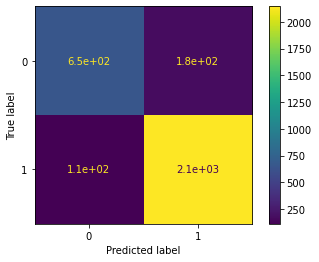

Dataset 3 : X1 --> D
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2732.000000  2732.000000  ...  2732.000000  2732.000000
mean      0.395681     1.737145  ...     0.531845     0.844817
std       0.489086     0.027980  ...     0.499076     0.507520
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.388261
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.7627737226277372
2 0.7846715328467153
3 0.7948717948717948
4 0.7875457875457875
5 0.7802197802197802
6 0.7802197802197802
7 0.7765567765567766
8 0.7728937728937729
9 0.7838827838827839
10 0.7912087912087912
0.7814844522873721


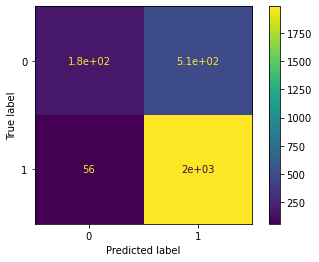

Dataset 4 : X1 --> E
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2430.000000  2430.000000  ...  2430.000000  2430.000000
mean      0.411111     1.737106  ...     0.544444     0.859489
std       0.492137     0.027585  ...     0.498123     0.513213
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.408800
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.7489711934156379
2 0.7160493827160493
3 0.7695473251028807
4 0.7489711934156379
5 0.7283950617283951
6 0.7448559670781894
7 0.7613168724279835
8 0.7736625514403292
9 0.7818930041152263
10 0.7613168724279835
0.7534979423868313


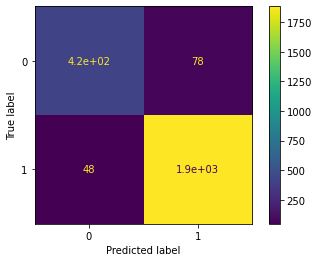

Dataset 5 : X1 --> F
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2164.000000  2164.000000  ...  2164.000000  2164.000000
mean      0.392329     1.736552  ...     0.489372     0.899512
std       0.488382     0.027211  ...     0.500003     0.529400
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     0.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.587564
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.7603686635944701
2 0.7695852534562212
3 0.7649769585253456
4 0.783410138248848
5 0.7222222222222222
6 0.7870370370370371
7 0.8009259259259259
8 0.8009259259259259
9 0.7546296296296297
10 0.7685185185185185
0.7712600273084144


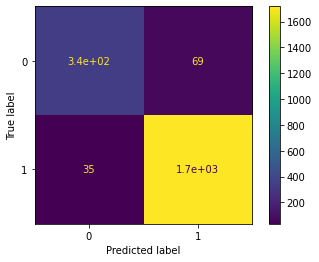

Dataset 6 : X1 --> G
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  637.000000  637.000000  ...  637.000000  637.000000
mean     0.279435    1.735296  ...    0.846154    0.561706
std      0.449074    0.023200  ...    0.361085    0.172011
min      0.000000    1.683065  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    1.000000    0.526589
50%      0.000000    1.732356  ...    1.000000    0.526589
75%      1.000000    1.752791  ...    1.000000    0.526589
max      1.000000    1.807264  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.671875
2 0.78125
3 0.71875
4 0.71875
5 0.6875
6 0.765625
7 0.796875
8 0.7301587301587301
9 0.7619047619047619
10 0.7301587301587301
0.7362847222222222


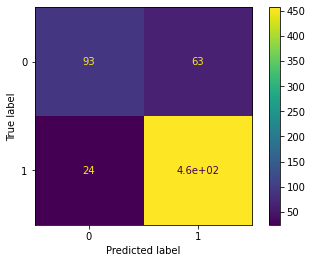

Dataset 7 : X1 --> H
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  990.000000  990.000000  ...  990.000000  990.000000
mean     0.389899    1.739040  ...    0.219192    1.107928
std      0.487974    0.025549  ...    0.413908    0.568659
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.720079  ...    0.000000    0.526589
50%      0.000000    1.737326  ...    0.000000    1.102583
75%      1.000000    1.755699  ...    0.000000    1.751315
max      1.000000    1.825195  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.8181818181818182
2 0.8686868686868687
3 0.8080808080808081
4 0.8585858585858586
5 0.8787878787878788
6 0.898989898989899
7 0.8383838383838383
8 0.8282828282828283
9 0.8787878787878788
10 0.8585858585858586
0.8535353535353535


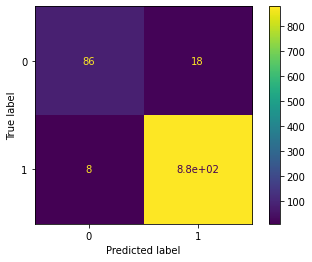

Dataset 8 : X1 --> I
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  383.000000  383.000000  ...  383.000000  383.000000
mean     0.409922    1.741570  ...    0.164491    1.128115
std      0.492462    0.025087  ...    0.371205    0.560507
min      0.000000    1.687642  ...    0.000000    0.526589
25%      0.000000    1.722792  ...    0.000000    0.526589
50%      0.000000    1.740550  ...    0.000000    1.162283
75%      1.000000    1.758551  ...    0.000000    1.751315
max      1.000000    1.813178  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.8717948717948718
2 0.8205128205128205
3 0.8717948717948718
4 0.8421052631578947
5 0.8421052631578947
6 0.8157894736842105
7 0.868421052631579
8 0.8421052631578947
9 0.7894736842105263
10 0.8421052631578947
0.8406207827260459


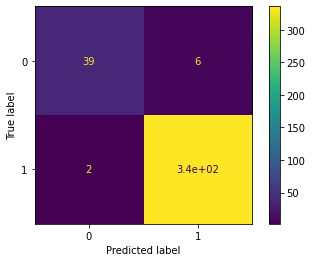

Dataset 9 : X1 --> J
       REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
count  120.000000  120.000000       120.000000  ...      120.0     120.0  120.000000
mean     0.533333    1.741172         0.883333  ...        0.0       1.0    0.533941
std      0.500979    0.028569         0.322369  ...        0.0       0.0    0.080534
min      0.000000    1.692090         0.000000  ...        0.0       1.0    0.526589
25%      0.000000    1.720079         1.000000  ...        0.0       1.0    0.526589
50%      1.000000    1.735688         1.000000  ...        0.0       1.0    0.526589
75%      1.000000    1.758551         1.000000  ...        0.0       1.0    0.526589
max      1.000000    1.837070         1.000000  ...        0.0       1.0    1.408800

[8 rows x 22 columns]
1 0.6666666666666666
2 0.6666666666666666
3 0.6666666666666666
4 0.75
5 0.6666666666666666
6 0.6666666666666666
7 0.6666666666666666
8 0.6666666666666666
9 0.75
10 0.75
0.6916666666666667


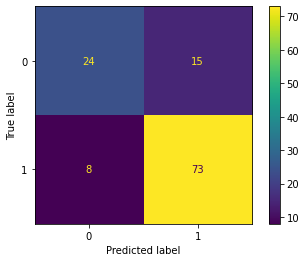

Dataset 10 : X1 --> K
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  567.000000  567.000000  ...  567.000000  567.000000
mean     0.398589    1.732672  ...    0.864198    0.621126
std      0.490040    0.028364  ...    0.342881    0.308336
min      0.000000    1.665905  ...    0.000000    0.526589
25%      0.000000    1.712589  ...    1.000000    0.526589
50%      0.000000    1.728949  ...    1.000000    0.526589
75%      1.000000    1.751315  ...    1.000000    0.526589
max      1.000000    1.855302  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.7719298245614035
2 0.7543859649122807
3 0.6666666666666666
4 0.7368421052631579
5 0.7719298245614035
6 0.7719298245614035
7 0.7017543859649122
8 0.7321428571428571
9 0.75
10 0.6071428571428571
0.7264724310776942


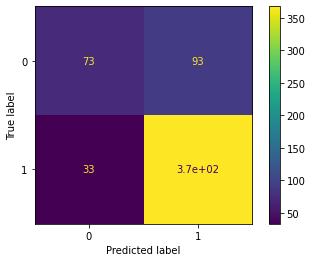

Dataset 11 : X1 --> L
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  536.000000  536.000000  ...  536.000000  536.000000
mean     0.375000    1.736716  ...    0.274254    1.085731
std      0.484575    0.025415  ...    0.446554    0.574779
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    0.000000    0.526589
50%      0.000000    1.735688  ...    0.000000    0.869742
75%      1.000000    1.752791  ...    1.000000    1.751315
max      1.000000    1.824307  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.8148148148148148
2 0.8518518518518519
3 0.8703703703703703
4 0.8703703703703703
5 0.7592592592592593
6 0.8518518518518519
7 0.7924528301886793
8 0.8679245283018868
9 0.8490566037735849
10 0.8490566037735849
0.8377009084556255


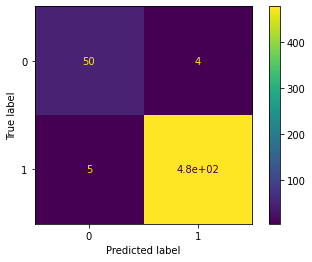

Dataset 12 : X1s --> A
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  4634.000000  4634.000000  ...  4634.000000  4634.000000
mean      0.384017     1.736919  ...     0.661356     0.759621
std       0.462944     0.027166  ...     0.458510     0.452632
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.718240  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.753823  ...     1.000000     0.526589
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.8168103448275862
2 0.8512931034482759
3 0.7995689655172413
4 0.7887931034482759
5 0.8077753779697624
6 0.7624190064794817
7 0.7645788336933045
8 0.8142548596112311
9 0.7796976241900648
10 0.7861771058315334
0.7971368325016757


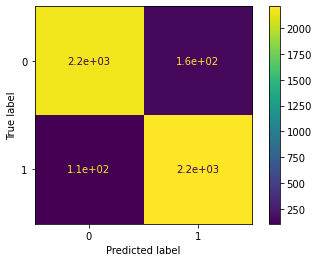

Dataset 13 : X1s --> B
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3946.000000  3946.000000  ...  3946.000000  3946.000000
mean      0.383715     1.736753  ...     0.639710     0.791665
std       0.456781     0.026217  ...     0.463633     0.471240
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.718229  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.753403  ...     1.000000     0.869742
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.850632911392405
2 0.830379746835443
3 0.8329113924050633
4 0.8632911392405064
5 0.8430379746835444
6 0.8658227848101265
7 0.8654822335025381
8 0.8350253807106599
9 0.8147208121827412
10 0.868020304568528
0.8469324680331555


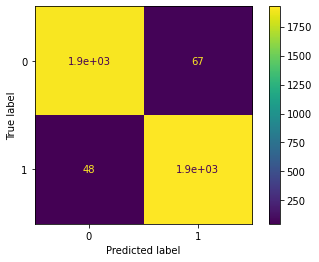

Dataset 14 : X1s --> C
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  4514.000000  4514.000000  ...  4514.000000  4514.000000
mean      0.384506     1.737271  ...     0.651776     0.766117
std       0.462383     0.027231  ...     0.461276     0.455819
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.718240  ...     0.000000     0.526589
50%       0.000000     1.734984  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     0.526589
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.7920353982300885
2 0.8097345132743363
3 0.7787610619469026
4 0.8429203539823009
5 0.8070953436807096
6 0.7893569844789357
7 0.7871396895787139
8 0.8093126385809313
9 0.8004434589800443
10 0.7716186252771619
0.7988418068010125


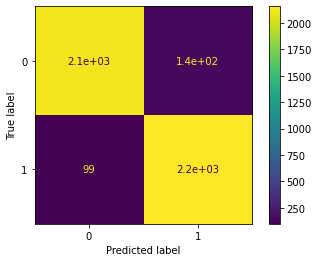

Dataset 15 : X1s --> D
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  4090.000000  4090.000000  ...  4090.000000  4090.000000
mean      0.367556     1.736201  ...     0.608613     0.789478
std       0.458780     0.026440  ...     0.469784     0.473103
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.717765  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.752791  ...     1.000000     0.529263
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.8410757946210269
2 0.8190709046454768
3 0.823960880195599
4 0.8264058679706602
5 0.7946210268948656
6 0.8166259168704156
7 0.7995110024449877
8 0.8190709046454768
9 0.8141809290953546
10 0.78239608801956
0.8136919315403425


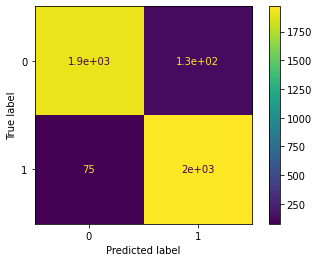

Dataset 16 : X1s --> E
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3862.000000  3862.000000  ...  3862.000000  3862.000000
mean      0.370165     1.736674  ...     0.631965     0.800715
std       0.455044     0.025758  ...     0.465028     0.474785
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.718240  ...     0.000000     0.526589
50%       0.000000     1.734047  ...     1.000000     0.526589
75%       1.000000     1.753094  ...     1.000000     0.962223
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.8372093023255814
2 0.8604651162790697
3 0.8575129533678757
4 0.8678756476683938
5 0.8134715025906736
6 0.8341968911917098
7 0.8264248704663213
8 0.8290155440414507
9 0.8264248704663213
10 0.8497409326424871
0.8402337631039885


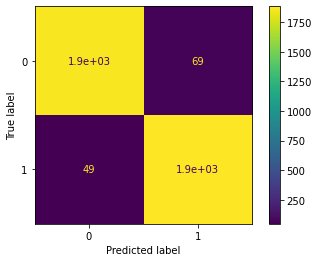

Dataset 17 : X1s --> F
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3506.000000  3506.000000  ...  3506.000000  3506.000000
mean      0.352784     1.736271  ...     0.582327     0.827784
std       0.450721     0.025655  ...     0.471732     0.489315
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.718053  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.752791  ...     1.000000     1.220630
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.8632478632478633
2 0.8603988603988604
3 0.8233618233618234
4 0.8404558404558404
5 0.8347578347578347
6 0.8319088319088319
7 0.9028571428571428
8 0.8885714285714286
9 0.8028571428571428
10 0.8428571428571429
0.8491273911273911


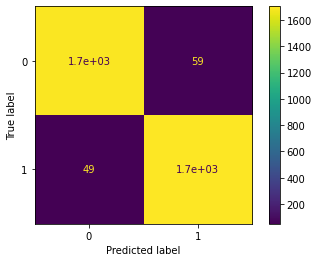

Dataset 18 : X1s --> G
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  962.000000  962.000000  ...  962.000000  962.000000
mean     0.241267    1.734886  ...    0.896990    0.549842
std      0.412142    0.021437  ...    0.303788    0.140917
min      0.000000    1.683065  ...    0.000000    0.526589
25%      0.000000    1.720079  ...    1.000000    0.526589
50%      0.000000    1.730940  ...    1.000000    0.526589
75%      0.408256    1.748689  ...    1.000000    0.526589
max      1.000000    1.807264  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.8041237113402062
2 0.8247422680412371
3 0.8229166666666666
4 0.8125
5 0.8125
6 0.8020833333333334
7 0.8125
8 0.84375
9 0.7708333333333334
10 0.7708333333333334
0.8076782646048108


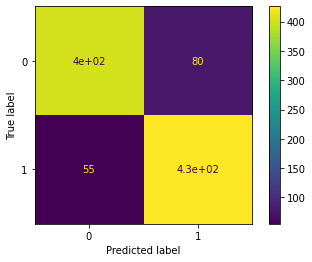

Dataset 19 : X1s --> H
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  1772.000000  1772.000000  ...  1772.000000  1772.000000
mean      0.341687     1.738901  ...     0.288275     1.073853
std       0.440685     0.024073  ...     0.424333     0.546712
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.720079  ...     0.000000     0.526589
50%       0.000000     1.737953  ...     0.000000     0.993608
75%       0.991294     1.754857  ...     0.751425     1.707643
max       1.000000     1.825195  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.9101123595505618
2 0.9550561797752809
3 0.8983050847457628
4 0.9491525423728814
5 0.943502824858757
6 0.96045197740113
7 0.9661016949152542
8 0.9209039548022598
9 0.9661016949152542
10 0.9548022598870056
0.9424490573224148


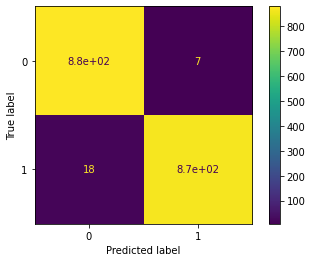

Dataset 20 : X1s --> I
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  676.000000  676.000000  ...  676.000000  676.000000
mean     0.360532    1.744026  ...    0.241479    1.075170
std      0.454526    0.023091  ...    0.406117    0.532197
min      0.000000    1.687642  ...    0.000000    0.526589
25%      0.000000    1.727216  ...    0.000000    0.526589
50%      0.000000    1.745260  ...    0.000000    1.026672
75%      1.000000    1.759483  ...    0.392776    1.701257
max      1.000000    1.813178  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.9852941176470589
2 0.9411764705882353
3 0.9558823529411765
4 0.9705882352941176
5 0.9411764705882353
6 0.9558823529411765
7 0.9253731343283582
8 0.9253731343283582
9 0.9402985074626866
10 0.9552238805970149
0.9496268656716417


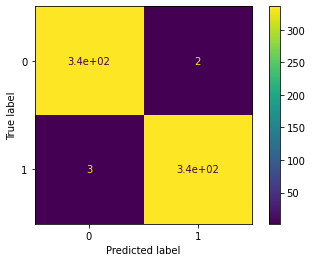

Dataset 21 : X1s --> J
       REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
count  162.000000  162.000000       162.000000  ...      162.0     162.0  162.000000
mean     0.506577    1.740939         0.873579  ...        0.0       1.0    0.532035
std      0.475045    0.027787         0.313968  ...        0.0       0.0    0.069313
min      0.000000    1.692090         0.000000  ...        0.0       1.0    0.526589
25%      0.000000    1.720079         1.000000  ...        0.0       1.0    0.526589
50%      0.579245    1.734613         1.000000  ...        0.0       1.0    0.526589
75%      1.000000    1.756481         1.000000  ...        0.0       1.0    0.526589
max      1.000000    1.837070         1.000000  ...        0.0       1.0    1.408800

[8 rows x 22 columns]
1 0.9411764705882353
2 0.7647058823529411
3 1.0
4 0.8125
5 0.9375
6 0.8125
7 0.8125
8 0.9375
9 0.75
10 0.9375
0.8705882352941178


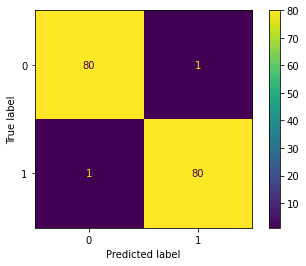

Dataset 22 : X1s --> K
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  802.000000  802.000000  ...  802.000000  802.000000
mean     0.360555    1.731588  ...    0.881156    0.594916
std      0.462695    0.026561  ...    0.314703    0.265735
min      0.000000    1.665905  ...    0.000000    0.526589
25%      0.000000    1.712707  ...    1.000000    0.526589
50%      0.000000    1.728092  ...    1.000000    0.526589
75%      1.000000    1.748466  ...    1.000000    0.526589
max      1.000000    1.855302  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.7407407407407407
2 0.8518518518518519
3 0.75
4 0.8
5 0.8125
6 0.85
7 0.8
8 0.7375
9 0.8875
10 0.75
0.7980092592592593


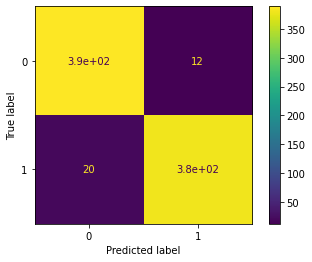

Dataset 23 : X1s --> L
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  964.000000  964.000000  ...  964.000000  964.000000
mean     0.344724    1.734309  ...    0.325695    1.039382
std      0.441143    0.022870  ...    0.435407    0.558678
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.716380  ...    0.000000    0.526589
50%      0.000000    1.734031  ...    0.000000    0.526589
75%      0.975923    1.749375  ...    0.930817    1.721235
max      1.000000    1.824307  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.979381443298969
2 0.9587628865979382
3 0.9484536082474226
4 0.9484536082474226
5 0.9166666666666666
6 0.9270833333333334
7 0.9270833333333334
8 0.9583333333333334
9 0.96875
10 0.9583333333333334
0.9491301546391753


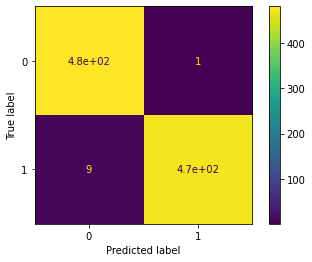

Dataset 24 : X2 --> A
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3181.000000  3181.000000  ...  3181.000000  3181.000000
mean      0.414335     1.737759  ...     0.596982     0.800510
std       0.492684     0.028485  ...     0.490581     0.483479
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     0.869742
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6175548589341693
2 0.610062893081761
3 0.6289308176100629
4 0.6320754716981132
5 0.6132075471698113
6 0.5974842767295597
7 0.6383647798742138
8 0.60062893081761
9 0.6257861635220126
10 0.6446540880503144
0.6208749827487628


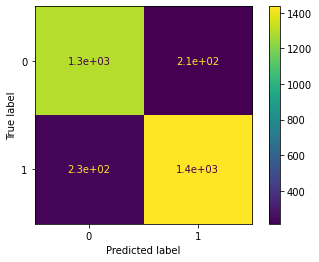

Dataset 25 : X2 --> B
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2482.000000  2482.000000  ...  2482.000000  2482.000000
mean      0.415391     1.737255  ...     0.553989     0.852515
std       0.492889     0.027631  ...     0.497177     0.510040
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.397363
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6506024096385542
2 0.6666666666666666
3 0.6975806451612904
4 0.6774193548387096
5 0.6612903225806451
6 0.6491935483870968
7 0.6491935483870968
8 0.6653225806451613
9 0.6733870967741935
10 0.6129032258064516
0.6603559398885868


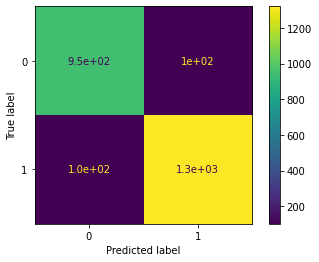

Dataset 26 : X2 --> C
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3091.000000  3091.000000  ...  3091.000000  3091.000000
mean      0.411194     1.737601  ...     0.585247     0.808485
std       0.492130     0.028367  ...     0.492759     0.488172
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.026672
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.5741935483870968
2 0.6601941747572816
3 0.6472491909385113
4 0.627831715210356
5 0.6537216828478964
6 0.6148867313915858
7 0.627831715210356
8 0.5760517799352751
9 0.5825242718446602
10 0.6343042071197411
0.6198789017642761


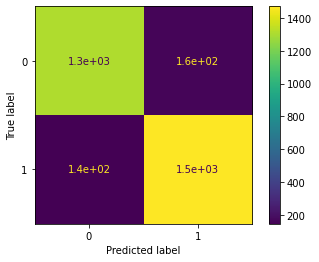

Dataset 27 : X2 --> D
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2732.000000  2732.000000  ...  2732.000000  2732.000000
mean      0.395681     1.737145  ...     0.531845     0.844817
std       0.489086     0.027980  ...     0.499076     0.507520
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.388261
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.5875912408759124
2 0.6459854014598541
3 0.6446886446886447
4 0.6263736263736264
5 0.5860805860805861
6 0.6410256410256411
7 0.5934065934065934
8 0.5934065934065934
9 0.6043956043956044
10 0.5970695970695971
0.6120023528782653


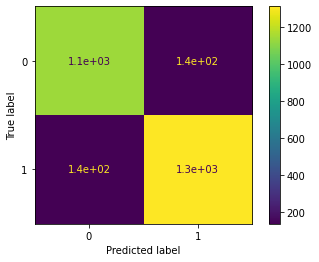

Dataset 28 : X2 --> E
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2430.000000  2430.000000  ...  2430.000000  2430.000000
mean      0.411111     1.737106  ...     0.544444     0.859489
std       0.492137     0.027585  ...     0.498123     0.513213
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.408800
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6625514403292181
2 0.6337448559670782
3 0.6502057613168725
4 0.6131687242798354
5 0.6131687242798354
6 0.6419753086419753
7 0.6872427983539094
8 0.6995884773662552
9 0.6831275720164609
10 0.6666666666666666
0.6551440329218108


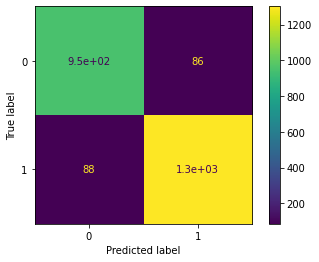

Dataset 29 : X2 --> F
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2164.000000  2164.000000  ...  2164.000000  2164.000000
mean      0.392329     1.736552  ...     0.489372     0.899512
std       0.488382     0.027211  ...     0.500003     0.529400
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     0.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.587564
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.6543778801843319
2 0.6497695852534562
3 0.6682027649769585
4 0.6405529953917051
5 0.6666666666666666
6 0.6481481481481481
7 0.6574074074074074
8 0.6620370370370371
9 0.6712962962962963
10 0.6620370370370371
0.6580495818399045


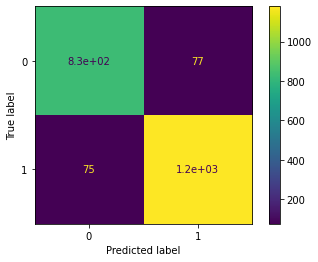

Dataset 30 : X2 --> G
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  637.000000  637.000000  ...  637.000000  637.000000
mean     0.279435    1.735296  ...    0.846154    0.561706
std      0.449074    0.023200  ...    0.361085    0.172011
min      0.000000    1.683065  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    1.000000    0.526589
50%      0.000000    1.732356  ...    1.000000    0.526589
75%      1.000000    1.752791  ...    1.000000    0.526589
max      1.000000    1.807264  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.703125
2 0.765625
3 0.546875
4 0.640625
5 0.734375
6 0.53125
7 0.625
8 0.6031746031746031
9 0.6825396825396826
10 0.5873015873015873
0.6419890873015872


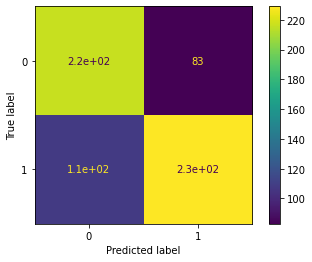

Dataset 31 : X2 --> H
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  990.000000  990.000000  ...  990.000000  990.000000
mean     0.389899    1.739040  ...    0.219192    1.107928
std      0.487974    0.025549  ...    0.413908    0.568659
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.720079  ...    0.000000    0.526589
50%      0.000000    1.737326  ...    0.000000    1.102583
75%      1.000000    1.755699  ...    0.000000    1.751315
max      1.000000    1.825195  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.7676767676767676
2 0.7171717171717171
3 0.7272727272727273
4 0.696969696969697
5 0.7878787878787878
6 0.7272727272727273
7 0.7575757575757576
8 0.6767676767676768
9 0.7272727272727273
10 0.7676767676767676
0.7353535353535353


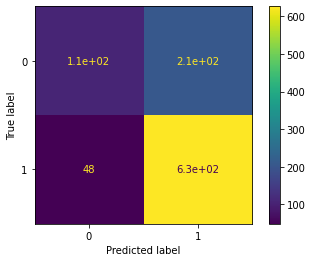

Dataset 32 : X2 --> I
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  383.000000  383.000000  ...  383.000000  383.000000
mean     0.409922    1.741570  ...    0.164491    1.128115
std      0.492462    0.025087  ...    0.371205    0.560507
min      0.000000    1.687642  ...    0.000000    0.526589
25%      0.000000    1.722792  ...    0.000000    0.526589
50%      0.000000    1.740550  ...    0.000000    1.162283
75%      1.000000    1.758551  ...    0.000000    1.751315
max      1.000000    1.813178  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.6923076923076923
2 0.6153846153846154
3 0.6410256410256411
4 0.631578947368421
5 0.7105263157894737
6 0.6578947368421053
7 0.7105263157894737
8 0.7631578947368421
9 0.7894736842105263
10 0.7631578947368421
0.6975033738191634


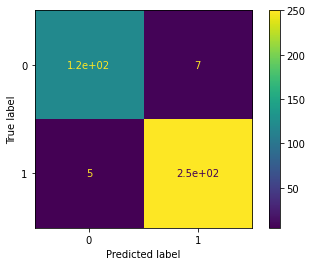

Dataset 33 : X2 --> J
       REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
count  120.000000  120.000000       120.000000  ...      120.0     120.0  120.000000
mean     0.533333    1.741172         0.883333  ...        0.0       1.0    0.533941
std      0.500979    0.028569         0.322369  ...        0.0       0.0    0.080534
min      0.000000    1.692090         0.000000  ...        0.0       1.0    0.526589
25%      0.000000    1.720079         1.000000  ...        0.0       1.0    0.526589
50%      1.000000    1.735688         1.000000  ...        0.0       1.0    0.526589
75%      1.000000    1.758551         1.000000  ...        0.0       1.0    0.526589
max      1.000000    1.837070         1.000000  ...        0.0       1.0    1.408800

[8 rows x 22 columns]
1 0.75
2 0.6666666666666666
3 0.75
4 0.5833333333333334
5 0.75
6 0.75
7 0.75
8 0.8333333333333334
9 0.75
10 0.6666666666666666
0.7250000000000001


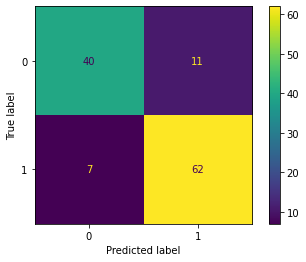

Dataset 34 : X2 --> K
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  567.000000  567.000000  ...  567.000000  567.000000
mean     0.398589    1.732672  ...    0.864198    0.621126
std      0.490040    0.028364  ...    0.342881    0.308336
min      0.000000    1.665905  ...    0.000000    0.526589
25%      0.000000    1.712589  ...    1.000000    0.526589
50%      0.000000    1.728949  ...    1.000000    0.526589
75%      1.000000    1.751315  ...    1.000000    0.526589
max      1.000000    1.855302  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.6666666666666666
2 0.7719298245614035
3 0.7017543859649122
4 0.6491228070175439
5 0.7192982456140351
6 0.7543859649122807
7 0.8245614035087719
8 0.5535714285714286
9 0.6785714285714286
10 0.7142857142857143
0.7034147869674187


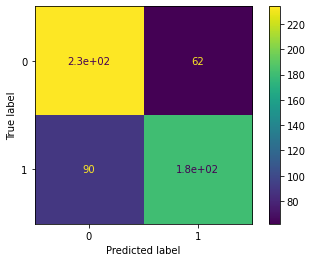

Dataset 35 : X2 --> L
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  536.000000  536.000000  ...  536.000000  536.000000
mean     0.375000    1.736716  ...    0.274254    1.085731
std      0.484575    0.025415  ...    0.446554    0.574779
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    0.000000    0.526589
50%      0.000000    1.735688  ...    0.000000    0.869742
75%      1.000000    1.752791  ...    1.000000    1.751315
max      1.000000    1.824307  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.5740740740740741
2 0.6481481481481481
3 0.6666666666666666
4 0.6666666666666666
5 0.7222222222222222
6 0.6481481481481481
7 0.6226415094339622
8 0.6415094339622641
9 0.5094339622641509
10 0.5471698113207547
0.6246680642907056


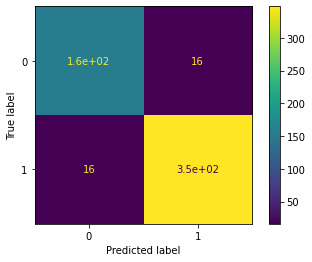

Dataset 36 : X3 --> A
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3181.000000  3181.000000  ...  3181.000000  3181.000000
mean      0.414335     1.737759  ...     0.596982     0.800510
std       0.492684     0.028485  ...     0.490581     0.483479
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     0.869742
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.40752351097178685
2 0.41823899371069184
3 0.4056603773584906
4 0.41509433962264153
5 0.41823899371069184
6 0.41823899371069184
7 0.4119496855345912
8 0.42138364779874216
9 0.39622641509433965
10 0.4559748427672956
0.41685298002799637


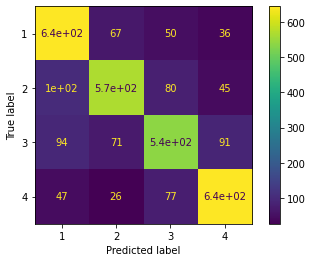

Dataset 37 : X3 --> B
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2482.000000  2482.000000  ...  2482.000000  2482.000000
mean      0.415391     1.737255  ...     0.553989     0.852515
std       0.492889     0.027631  ...     0.497177     0.510040
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.397363
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.40963855421686746
2 0.4738955823293173
3 0.4314516129032258
4 0.4717741935483871
5 0.43951612903225806
6 0.43951612903225806
7 0.4959677419354839
8 0.4838709677419355
9 0.45564516129032256
10 0.4798387096774194
0.4581114781707475


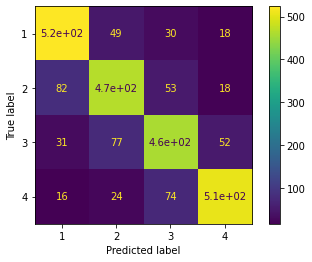

Dataset 38 : X3 --> C
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3091.000000  3091.000000  ...  3091.000000  3091.000000
mean      0.411194     1.737601  ...     0.585247     0.808485
std       0.492130     0.028367  ...     0.492759     0.488172
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.026672
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.3967741935483871
2 0.4174757281553398
3 0.42718446601941745
4 0.4077669902912621
5 0.42394822006472493
6 0.4336569579288026
7 0.4174757281553398
8 0.3851132686084142
9 0.3786407766990291
10 0.3592233009708738
0.4047259630441591


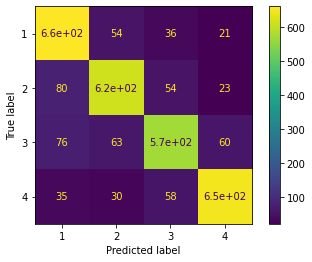

Dataset 39 : X3 --> D
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2732.000000  2732.000000  ...  2732.000000  2732.000000
mean      0.395681     1.737145  ...     0.531845     0.844817
std       0.489086     0.027980  ...     0.499076     0.507520
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.388261
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.42700729927007297
2 0.43795620437956206
3 0.43223443223443225
4 0.3992673992673993
5 0.4432234432234432
6 0.4139194139194139
7 0.38461538461538464
8 0.39194139194139194
9 0.4249084249084249
10 0.358974358974359
0.41140477527338837


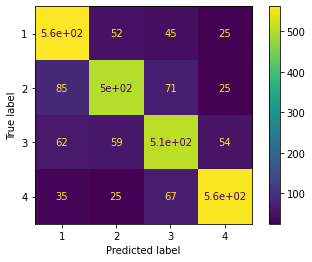

Dataset 40 : X3 --> E
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2430.000000  2430.000000  ...  2430.000000  2430.000000
mean      0.411111     1.737106  ...     0.544444     0.859489
std       0.492137     0.027585  ...     0.498123     0.513213
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.408800
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.448559670781893
2 0.4897119341563786
3 0.48148148148148145
4 0.4279835390946502
5 0.4074074074074074
6 0.5102880658436214
7 0.4732510288065844
8 0.39094650205761317
9 0.448559670781893
10 0.43621399176954734
0.451440329218107


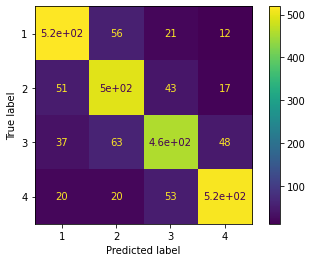

Dataset 41 : X3 --> F
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2164.000000  2164.000000  ...  2164.000000  2164.000000
mean      0.392329     1.736552  ...     0.489372     0.899512
std       0.488382     0.027211  ...     0.500003     0.529400
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     0.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.587564
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.5299539170506913
2 0.5483870967741935
3 0.5898617511520737
4 0.5668202764976958
5 0.5185185185185185
6 0.5462962962962963
7 0.5601851851851852
8 0.5555555555555556
9 0.5092592592592593
10 0.49537037037037035
0.542020822665984


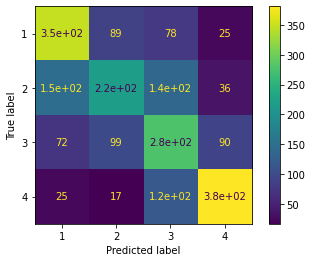

Dataset 42 : X3 --> G
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  637.000000  637.000000  ...  637.000000  637.000000
mean     0.279435    1.735296  ...    0.846154    0.561706
std      0.449074    0.023200  ...    0.361085    0.172011
min      0.000000    1.683065  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    1.000000    0.526589
50%      0.000000    1.732356  ...    1.000000    0.526589
75%      1.000000    1.752791  ...    1.000000    0.526589
max      1.000000    1.807264  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.328125
2 0.390625
3 0.5
4 0.390625
5 0.359375
6 0.46875
7 0.359375
8 0.4126984126984127
9 0.4444444444444444
10 0.4603174603174603
0.4114335317460317


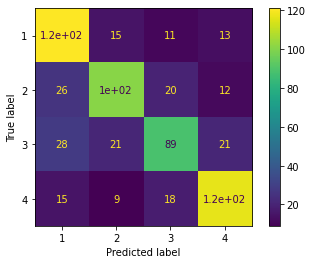

Dataset 43 : X3 --> H
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  990.000000  990.000000  ...  990.000000  990.000000
mean     0.389899    1.739040  ...    0.219192    1.107928
std      0.487974    0.025549  ...    0.413908    0.568659
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.720079  ...    0.000000    0.526589
50%      0.000000    1.737326  ...    0.000000    1.102583
75%      1.000000    1.755699  ...    0.000000    1.751315
max      1.000000    1.825195  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.5252525252525253
2 0.5050505050505051
3 0.5151515151515151
4 0.5151515151515151
5 0.5656565656565656
6 0.5555555555555556
7 0.5151515151515151
8 0.43434343434343436
9 0.494949494949495
10 0.5757575757575758
0.5202020202020202


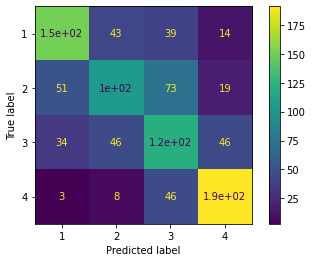

Dataset 44 : X3 --> I
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  383.000000  383.000000  ...  383.000000  383.000000
mean     0.409922    1.741570  ...    0.164491    1.128115
std      0.492462    0.025087  ...    0.371205    0.560507
min      0.000000    1.687642  ...    0.000000    0.526589
25%      0.000000    1.722792  ...    0.000000    0.526589
50%      0.000000    1.740550  ...    0.000000    1.162283
75%      1.000000    1.758551  ...    0.000000    1.751315
max      1.000000    1.813178  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.46153846153846156
2 0.46153846153846156
3 0.5128205128205128
4 0.5789473684210527
5 0.6578947368421053
6 0.5526315789473685
7 0.4473684210526316
8 0.5526315789473685
9 0.5263157894736842
10 0.5263157894736842
0.527800269905533


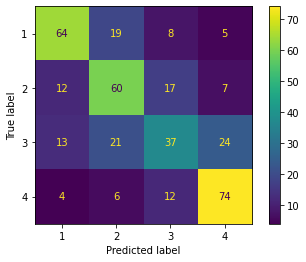

Dataset 45 : X3 --> J
       REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
count  120.000000  120.000000       120.000000  ...      120.0     120.0  120.000000
mean     0.533333    1.741172         0.883333  ...        0.0       1.0    0.533941
std      0.500979    0.028569         0.322369  ...        0.0       0.0    0.080534
min      0.000000    1.692090         0.000000  ...        0.0       1.0    0.526589
25%      0.000000    1.720079         1.000000  ...        0.0       1.0    0.526589
50%      1.000000    1.735688         1.000000  ...        0.0       1.0    0.526589
75%      1.000000    1.758551         1.000000  ...        0.0       1.0    0.526589
max      1.000000    1.837070         1.000000  ...        0.0       1.0    1.408800

[8 rows x 22 columns]
1 0.5
2 0.3333333333333333
3 0.3333333333333333
4 0.4166666666666667
5 0.16666666666666666
6 0.3333333333333333
7 0.3333333333333333
8 0.3333333333333333
9 0.4166666666666667
10 0.1666666666

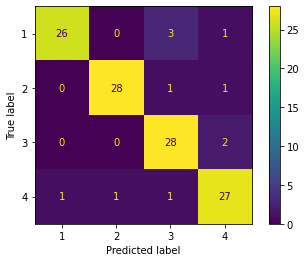

Dataset 46 : X3 --> K
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  567.000000  567.000000  ...  567.000000  567.000000
mean     0.398589    1.732672  ...    0.864198    0.621126
std      0.490040    0.028364  ...    0.342881    0.308336
min      0.000000    1.665905  ...    0.000000    0.526589
25%      0.000000    1.712589  ...    1.000000    0.526589
50%      0.000000    1.728949  ...    1.000000    0.526589
75%      1.000000    1.751315  ...    1.000000    0.526589
max      1.000000    1.855302  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.49122807017543857
2 0.47368421052631576
3 0.42105263157894735
4 0.3684210526315789
5 0.40350877192982454
6 0.5087719298245614
7 0.45614035087719296
8 0.5892857142857143
9 0.5178571428571429
10 0.5178571428571429
0.474780701754386


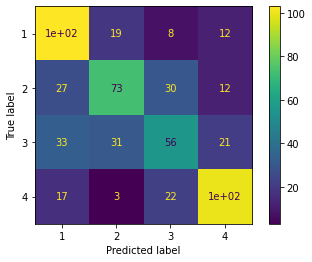

Dataset 47 : X3 --> L
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  536.000000  536.000000  ...  536.000000  536.000000
mean     0.375000    1.736716  ...    0.274254    1.085731
std      0.484575    0.025415  ...    0.446554    0.574779
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    0.000000    0.526589
50%      0.000000    1.735688  ...    0.000000    0.869742
75%      1.000000    1.752791  ...    1.000000    1.751315
max      1.000000    1.824307  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.46296296296296297
2 0.6481481481481481
3 0.4074074074074074
4 0.48148148148148145
5 0.42592592592592593
6 0.5
7 0.4339622641509434
8 0.5660377358490566
9 0.4339622641509434
10 0.49056603773584906
0.4850454227812719


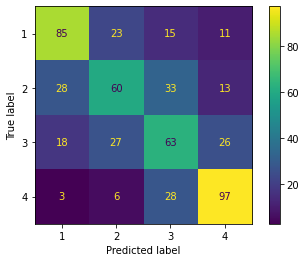

Dataset 48 : X8 --> A
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3181.000000  3181.000000  ...  3181.000000  3181.000000
mean      0.414335     1.737759  ...     0.596982     0.800510
std       0.492684     0.028485  ...     0.490581     0.483479
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     0.869742
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.3448275862068966
2 0.3333333333333333
3 0.3490566037735849
4 0.31446540880503143
5 0.3270440251572327
6 0.37735849056603776
7 0.34591194968553457
8 0.34276729559748426
9 0.37735849056603776
10 0.36163522012578614
0.3473758403816959


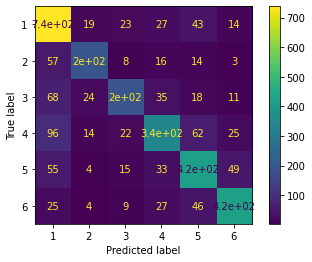

Dataset 49 : X8 --> B
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2482.000000  2482.000000  ...  2482.000000  2482.000000
mean      0.415391     1.737255  ...     0.553989     0.852515
std       0.492889     0.027631  ...     0.497177     0.510040
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.397363
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.3895582329317269
2 0.37751004016064255
3 0.3588709677419355
4 0.36693548387096775
5 0.375
6 0.43548387096774194
7 0.375
8 0.36693548387096775
9 0.3951612903225806
10 0.36693548387096775
0.380739085373753


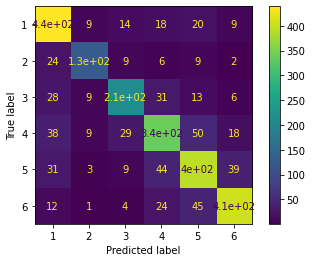

Dataset 50 : X8 --> C
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  3091.000000  3091.000000  ...  3091.000000  3091.000000
mean      0.411194     1.737601  ...     0.585247     0.808485
std       0.492130     0.028367  ...     0.492759     0.488172
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.026672
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.31290322580645163
2 0.2912621359223301
3 0.3333333333333333
4 0.36893203883495146
5 0.313915857605178
6 0.33980582524271846
7 0.37540453074433655
8 0.33980582524271846
9 0.343042071197411
10 0.33980582524271846
0.3358210669172147


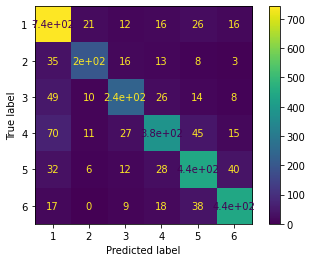

Dataset 51 : X8 --> D
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2732.000000  2732.000000  ...  2732.000000  2732.000000
mean      0.395681     1.737145  ...     0.531845     0.844817
std       0.489086     0.027980  ...     0.499076     0.507520
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.735688  ...     1.000000     0.526589
75%       1.000000     1.755699  ...     1.000000     1.388261
max       1.000000     1.918998  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.3175182481751825
2 0.3467153284671533
3 0.37362637362637363
4 0.31135531135531136
5 0.29304029304029305
6 0.3333333333333333
7 0.3333333333333333
8 0.31868131868131866
9 0.34798534798534797
10 0.34798534798534797
0.3323574235982995


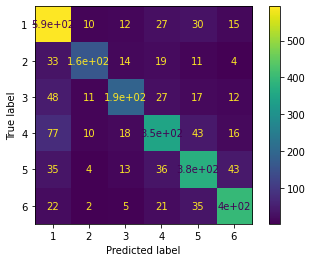

Dataset 52 : X8 --> E
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2430.000000  2430.000000  ...  2430.000000  2430.000000
mean      0.411111     1.737106  ...     0.544444     0.859489
std       0.492137     0.027585  ...     0.498123     0.513213
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     1.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.408800
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.35390946502057613
2 0.35802469135802467
3 0.37448559670781895
4 0.3950617283950617
5 0.37037037037037035
6 0.43621399176954734
7 0.3950617283950617
8 0.3374485596707819
9 0.3333333333333333
10 0.3662551440329218
0.3720164609053498


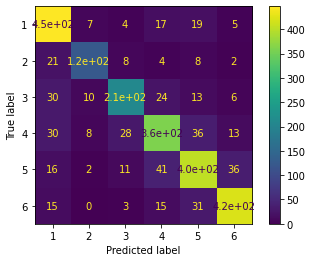

Dataset 53 : X8 --> F
        REL_SEASON      RUNTIME  ...     DOMESTIC     NMARKETS
count  2164.000000  2164.000000  ...  2164.000000  2164.000000
mean      0.392329     1.736552  ...     0.489372     0.899512
std       0.488382     0.027211  ...     0.500003     0.529400
min       0.000000     1.640720  ...     0.000000     0.526589
25%       0.000000     1.716380  ...     0.000000     0.526589
50%       0.000000     1.734031  ...     0.000000     0.526589
75%       1.000000     1.754252  ...     1.000000     1.587564
max       1.000000     1.855302  ...     1.000000     1.752791

[8 rows x 22 columns]
1 0.423963133640553
2 0.46543778801843316
3 0.4700460829493088
4 0.41935483870967744
5 0.4583333333333333
6 0.49537037037037035
7 0.4398148148148148
8 0.48148148148148145
9 0.47685185185185186
10 0.48148148148148145
0.46121351766513063


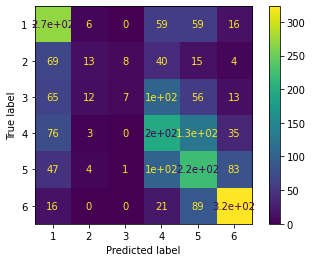

Dataset 54 : X8 --> G
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  637.000000  637.000000  ...  637.000000  637.000000
mean     0.279435    1.735296  ...    0.846154    0.561706
std      0.449074    0.023200  ...    0.361085    0.172011
min      0.000000    1.683065  ...    0.000000    0.526589
25%      0.000000    1.718240  ...    1.000000    0.526589
50%      0.000000    1.732356  ...    1.000000    0.526589
75%      1.000000    1.752791  ...    1.000000    0.526589
max      1.000000    1.807264  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.40625
2 0.375
3 0.34375
4 0.359375
5 0.21875
6 0.34375
7 0.328125
8 0.2698412698412698
9 0.25396825396825395
10 0.36507936507936506
0.3263888888888889


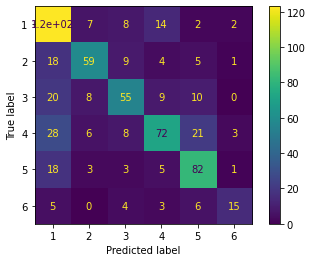

Dataset 55 : X8 --> H
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  990.000000  990.000000  ...  990.000000  990.000000
mean     0.389899    1.739040  ...    0.219192    1.107928
std      0.487974    0.025549  ...    0.413908    0.568659
min      0.000000    1.640720  ...    0.000000    0.526589
25%      0.000000    1.720079  ...    0.000000    0.526589
50%      0.000000    1.737326  ...    0.000000    1.102583
75%      1.000000    1.755699  ...    0.000000    1.751315
max      1.000000    1.825195  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.5151515151515151
2 0.45454545454545453
3 0.47474747474747475
4 0.5151515151515151
5 0.41414141414141414
6 0.47474747474747475
7 0.45454545454545453
8 0.3838383838383838
9 0.42424242424242425
10 0.45454545454545453
0.4565656565656565


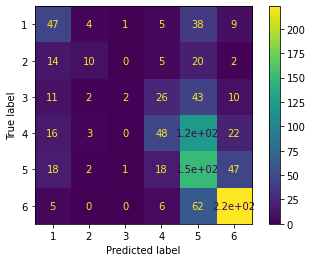

Dataset 56 : X8 --> I
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  383.000000  383.000000  ...  383.000000  383.000000
mean     0.409922    1.741570  ...    0.164491    1.128115
std      0.492462    0.025087  ...    0.371205    0.560507
min      0.000000    1.687642  ...    0.000000    0.526589
25%      0.000000    1.722792  ...    0.000000    0.526589
50%      0.000000    1.740550  ...    0.000000    1.162283
75%      1.000000    1.758551  ...    0.000000    1.751315
max      1.000000    1.813178  ...    1.000000    1.752791

[8 rows x 22 columns]
1 0.358974358974359
2 0.41025641025641024
3 0.4358974358974359
4 0.4473684210526316
5 0.3684210526315789
6 0.3684210526315789
7 0.39473684210526316
8 0.34210526315789475
9 0.3157894736842105
10 0.39473684210526316
0.3836707152496627


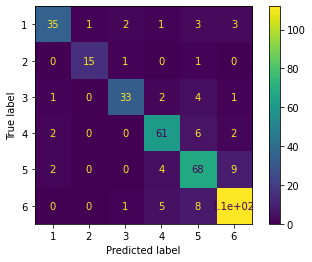

Dataset 57 : X8 --> J
       REL_SEASON     RUNTIME  BIG_DISTRIBUTOR  ...  MPAA_NC17  DOMESTIC    NMARKETS
count  120.000000  120.000000       120.000000  ...      120.0     120.0  120.000000
mean     0.533333    1.741172         0.883333  ...        0.0       1.0    0.533941
std      0.500979    0.028569         0.322369  ...        0.0       0.0    0.080534
min      0.000000    1.692090         0.000000  ...        0.0       1.0    0.526589
25%      0.000000    1.720079         1.000000  ...        0.0       1.0    0.526589
50%      1.000000    1.735688         1.000000  ...        0.0       1.0    0.526589
75%      1.000000    1.758551         1.000000  ...        0.0       1.0    0.526589
max      1.000000    1.837070         1.000000  ...        0.0       1.0    1.408800

[8 rows x 22 columns]
1 0.25
2 0.4166666666666667
3 0.4166666666666667
4 0.3333333333333333
5 0.25
6 0.3333333333333333
7 0.16666666666666666
8 0.16666666666666666
9 0.4166666666666667
10 0.4166666666666667
0.316

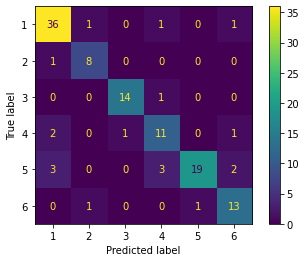

Dataset 58 : X8 --> K
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  567.000000  567.000000  ...  567.000000  567.000000
mean     0.398589    4.658028  ...    0.864198    0.986179
std      0.490040    0.161921  ...    0.342881    0.973252
min      0.000000    4.290459  ...    0.000000    0.693147
25%      0.000000    4.543295  ...    1.000000    0.693147
50%      0.000000    4.634729  ...    1.000000    0.693147
75%      1.000000    4.762174  ...    1.000000    0.693147
max      1.000000    5.393628  ...    1.000000    4.770685

[8 rows x 22 columns]
1 0.38596491228070173
2 0.42105263157894735
3 0.3508771929824561
4 0.40350877192982454
5 0.3333333333333333
6 0.2982456140350877
7 0.3157894736842105
8 0.32142857142857145
9 0.35714285714285715
10 0.4642857142857143
0.36516290726817047


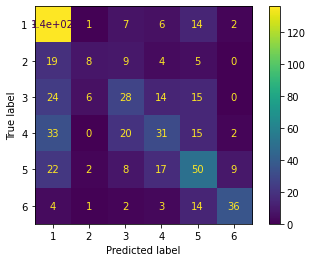

Dataset 59 : X8 --> L
       REL_SEASON     RUNTIME  ...    DOMESTIC    NMARKETS
count  536.000000  536.000000  ...  536.000000  536.000000
mean     0.375000    4.680502  ...    0.274254    2.478039
std      0.484575    0.144973  ...    0.446554    1.885866
min      0.000000    4.158883  ...    0.000000    0.693147
25%      0.000000    4.574711  ...    0.000000    0.693147
50%      0.000000    4.672829  ...    0.000000    1.386294
75%      1.000000    4.770685  ...    1.000000    4.762174
max      1.000000    5.198497  ...    1.000000    4.770685

[8 rows x 22 columns]
1 0.3333333333333333
2 0.3888888888888889
3 0.3333333333333333
4 0.3333333333333333
5 0.3148148148148148
6 0.37037037037037035
7 0.2830188679245283
8 0.33962264150943394
9 0.39622641509433965
10 0.3584905660377358
0.3451432564640112


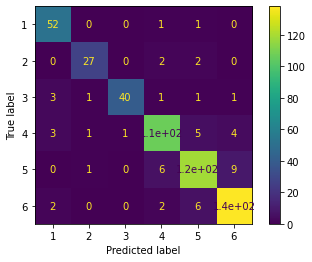

In [ ]:
#SVM
        #X1
params=[{'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},

        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}, 
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'},

        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},

        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}, 
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},

        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}, 
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 200, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 1, 'class_weight': 'balanced', 'coef0': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'},
        {'C': 100, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'},
        {'C': 50, 'class_weight': 'balanced', 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

]

Resultados = pd.DataFrame()
i=0
n=0
for sets, Y in zip(SetsX, SetsY):
  j=0
  text = []
  for X, y in zip(sets, Y):
    print("Dataset", n, ":", SetsX_names[i], "-->", datanames[j])

    Acur = []; Conf = []; loss = []; 
    Prec = []; Recall = []; FBeta = []; Support = []

    #DiscFeats = ['FIRSTWEEK_THEATERS', 'DEF_BUDGET', 'RUNTIME', 'NMARKETS']
    #for feat in DiscFeats:
    #  X[feat] = np.log(X[feat]+1)
    
    print(X.describe())
    cols = X.columns
    X = X.to_numpy()

    scaling = MinMaxScaler(feature_range=(-1,1)).fit(X)
    X = scaling.transform(X)

    #Roda StratifiedKFold que separa em K pastas e mantém a estratificação (gera apenas os índices)
    sample = StratifiedKFold(n_splits=10, shuffle=True, random_state=123) 
    cv_n = 1
    for train_index, test_index in sample.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      
      model = svm.SVC(C = params[n]['C'], kernel = params[n]['kernel'], degree = params[n]['degree'], 
                      coef0 = params[n]['coef0'], gamma = params[n]['gamma']) 
      model.fit(X_train, y_train)
      pred = model.predict(X_test)

      #Rev.append(metrics.recall_score(y_test, pred))
      #Prec.append(metrics.precision_score(y_test, pred))
      Acur.append(metrics.accuracy_score(y_test, pred))
      Conf.append(metrics.confusion_matrix(y_test, pred))
      Eita = precision_recall_fscore_support(y_test, pred)
      Prec.append(Eita[0]) # 0 precisionfloat (if average is not None) or array of float, shape = [n_unique_labels]
      Recall.append(Eita[1]) # 1 recallfloat (if average is not None) or array of float, , shape = [n_unique_labels]
      FBeta.append(Eita[2]) # 2 fbeta_scorefloat (if average is not None) or array of float, shape = [n_unique_labels]
      Support.append(Eita[3]) # 3 supportNone (if average is not None) or array of int, shape = [n_unique_labels]   
      
      print(cv_n, metrics.accuracy_score(y_test, pred))
      cv_n = cv_n+1
    
    #print(model)
    print(np.mean(Acur))
    plot_confusion_matrix(model, X, y)  # doctest: +SKIP
    plt.show()
    
    #ICAcur = sms.DescrStatsW(Acur).tconfint_mean()
    #ICPrec = sms.DescrStatsW(Prec).tconfint_mean()
    #ICRev = sms.DescrStatsW(Rev).tconfint_mean()

    Resultados = Resultados.append({'Dataset': str(SetsX_names[i]) + "_" + str(datanames[j]) ,
                       'Params':model, 'Acuracia': np.mean(Acur)}, ignore_index=True)
    j = j+1
    n = n+1
  #print(Resultados)
  i = i+1
Resultados.to_excel('SVM6_MinMax_X1238_ABCDEFGHIJKL.xlsx')

# Visualizations

In [ ]:
#profit = gross - budget
#gross = profit + budget
data['GROSS'] = data['DEF_BUDGET'] + data['PROFIT']
data

,MOVIEID,ANO,REL_SEASON,RUNTIME,BIG_DISTRIBUTOR,MARKETS,FIRSTWEEK_THEATERS,DEF_BUDGET,GENRE_ACTION,GENRE_ADVENTURE,GENRE_BIOGRAPHY,GENRE_COMEDY,GENRE_CRIME,GENRE_DRAMA,GENRE_FANTASY,GENRE_HORROR,GENRE_MUSIC,GENRE_SCIFI,MPAA_G,MPAA_PG,MPAA_PG13,MPAA_R,MPAA_NC17,PROFIT,IS_PROFITABLE,GROSS
0,tt0080684,1980,1,2 hr 4,1,Domestic,126,8.613240e+06,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,2.535544e+08,1,2.621676e+08
1,tt0080934,1980,1,1 hr 49,1,Domestic,584,1.052729e+07,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,-3.006582e+06,0,7.520712e+06
3,tt0081747,1980,0,2 hr 1,1,Domestic,677,9.570267e+06,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,-7.769149e+06,0,1.801119e+06
4,tt0082971,1981,1,1 hr 55,1,Domestic,1078,9.501742e+06,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1.964397e+08,1,2.059414e+08
5,tt0081573,1980,1,2 hr 7,1,Domestic,1397,2.850523e+07,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,2.860326e+07,1,5.710848e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,tt4587656,2017,1,1 hr 26,1,France,2837,2.846000e+07,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,6.098478e+07,1,8.944478e+07
3177,tt0359423,2004,1,1 hr 37,0,Domestic,5,7.130500e+06,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,-5.326316e+06,0,1.804184e+06
3178,tt1274300,2010,1,1 hr 50,1,Domestic,6,2.532000e+07,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,-2.488121e+07,0,4.387880e+05
3179,tt2191701,2013,1,1 hr 41,1,EMEA,3491,1.082400e+08,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2.259297e+08,1,3.341697e+08


In [ ]:
# Exploring Data (Full without normalizations yet)
# How many movies by year?
# How about genres?
# How about Opening Weeks? -> Median, Average, min and max by year
# How about budget and gross? Two ball graphs (volume $)
# How about classes? - BE, MM and PR

In [ ]:
fig1 = px.scatter(data, x="DEF_BUDGET", y="GROSS", template="plotly_white", color="IS_PROFITABLE")
fig1.show()

In [ ]:
## Movies by year
fig1 = px.histogram(data, x="ANO", color="IS_PROFITABLE", barmode='stack', color_discrete_map={
                1: "#D989E8",
                0: "#2199D7"},
             title="Profitable x Non-Profitable Releases by Year", template="plotly_white", labels={'IS_PROFITABLE':'Profitable'})

fig1.show()

wide = data[data["FIRSTWEEK_THEATERS"] >= 600]
fig1 = px.histogram(wide, x="ANO", color="IS_PROFITABLE", barmode='stack', color_discrete_map={
                1: "#D989E8",
                0: "#2199D7"},
             title="Profitable x Non-Profitable Releases by Year", template="plotly_white", labels={'IS_PROFITABLE':'Profitable'})

fig1.show()

In [ ]:
# How about genres?
fig = px.density_heatmap(data, y="DEF_BUDGET", x="IS_PROFITABLE", marginal_y="box")
fig.show()
fig = px.density_heatmap(data, y="GROSS", x="IS_PROFITABLE", marginal_y="box")
fig.show()

In [ ]:
action = data[data["GENRE_ACTION"] == 1]
action['genre'] = 'Action'
adventure = data[data["GENRE_ADVENTURE"] == 1]
adventure['genre'] = 'Adventure'
biography = data[data["GENRE_BIOGRAPHY"] == 1]
biography['genre'] = 'Biography'
comedy = data[data["GENRE_COMEDY"] == 1]
comedy['genre'] = 'Comedy'
crime = data[data["GENRE_CRIME"] == 1]
crime['genre'] = 'Crime'
fantasy = data[data["GENRE_FANTASY"] == 1]
fantasy['genre'] = 'Fantasy'
scifi = data[data["GENRE_SCIFI"] == 1]
scifi['genre'] = 'Sci-Fi'
horror = data[data["GENRE_HORROR"] == 1]
horror['genre'] = 'Horror'
music = data[data["GENRE_MUSIC"] == 1]
music['genre'] = 'Music'
drama = data[data["GENRE_DRAMA"] == 1]
drama['genre'] = 'Drama'

newdf = pd.concat([action, adventure, biography, comedy, crime, fantasy, scifi, horror, music, drama])

genres = newdf['genre'].value_counts()
genres = pd.DataFrame(genres)
genres

In [ ]:
fig = px.histogram(newdf, x="ANO", color="genre", barmode='stack',
             title="Genres By Year", template="plotly_white")
fig.show()

fig = px.histogram(newdf, x="genre", color="genre", barmode='stack',
             title="Genres Distributions", template="plotly_white")
fig.show()

labels=genres.index
fig = px.pie(genres, values='genre', names=genres.index, title='Genres Distributions', labels=labels)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
MPAA_G = data[data['MPAA_G']==1]
MPAA_G['mpaa'] = 'G'
MPAA_PG = data[data['MPAA_PG']==1]
MPAA_PG['mpaa'] = 'PG'
MPAA_PG13	= data[data['MPAA_PG13']==1]
MPAA_PG13['mpaa'] = 'PG-13'
MPAA_R = data[data['MPAA_R']==1]
MPAA_R['mpaa'] = 'R'
MPAA_NC17 = data[data['MPAA_NC17']==1]
MPAA_NC17['mpaa'] = 'NC-17'

dfmpaa = pd.concat([MPAA_G, MPAA_PG, MPAA_PG13, MPAA_R, MPAA_NC17])

In [ ]:
# How about Opening Weeks? -> Median, Average, min and max by year and/or genre and/or MPAA

fig = fig = px.box(data, y="FIRSTWEEK_THEATERS", x='ANO', template='plotly_white', title="First Week Theaters by Year")
fig.show()

fig = fig = px.box(data, y="FIRSTWEEK_THEATERS", x='ANO', template='plotly_white', color="IS_PROFITABLE", title="First Week Theaters by Year and BE Class")
fig.show()

fig = fig = px.box(newdf, y="FIRSTWEEK_THEATERS", x='genre', template='plotly_white', title="First Week Theaters by Genre")
fig.show()

fig = fig = px.box(newdf, y="FIRSTWEEK_THEATERS", x='genre', template='plotly_white', color="IS_PROFITABLE", title="First Week Theaters By Genre and BE Class")
fig.show()

fig = fig = px.box(dfmpaa, y="FIRSTWEEK_THEATERS", x='mpaa', template='plotly_white', title="First Week Theaters by MPAA")
fig.show()

fig = fig = px.box(dfmpaa, y="FIRSTWEEK_THEATERS", x='mpaa', template='plotly_white', color="IS_PROFITABLE", title="First Week Theaters by MPAA and BE Class")
fig.show()

In [ ]:
# How about budget and gross? Two ball graphs (volume $)
# How about classes? - BE, MM and PR
fig = px.scatter(data, x="DEF_BUDGET", y="GROSS", color="PROFIT",
                 log_x=True, size_max=60, template='plotly_white')
fig.show()

In [ ]:
X = data.copy()
X['X8'] = 0
X.loc[X['PROFIT'] < 0, 'X8'] = '1'
X.loc[(X['PROFIT'] >= 0) & (X['PROFIT'] < 10000000), 'X8'] = '2'
X.loc[(X['PROFIT'] >= 10000000) & (X['PROFIT'] < 30000000), 'X8'] = '3'
X.loc[(X['PROFIT'] >= 30000000) & (X['PROFIT'] < 80000000), 'X8'] = '4'
X.loc[(X['PROFIT'] >= 80000000) & (X['PROFIT'] < 200000000), 'X8'] = '5'
X.loc[X['PROFIT'] > 200000000, 'X8'] = '6'
X

In [ ]:
fig = px.scatter(X, x="DEF_BUDGET", y="PROFIT", color="X8", size="GROSS",
                 log_x=True, size_max=60, template='plotly_white', title='Profit Ranges: Budget x Profit')
fig.show()

In [ ]:
groupyear = data[['ANO', 'DEF_BUDGET', 'GROSS', 'PROFIT', 'FIRSTWEEK_THEATERS']]
groupyear = groupyear.groupby(['ANO']).sum()
groupyear['ANO'] = groupyear.index
groupyear

,DEF_BUDGET,GROSS,PROFIT,FIRSTWEEK_THEATERS,ANO
ANO,,,,,
1980,5.721603e+07,3.285979e+08,2.713819e+08,2784,1980
1981,5.217189e+07,2.301730e+08,1.780011e+08,2765,1981
1982,5.138821e+07,6.770595e+08,6.256713e+08,5960,1982
1983,5.860859e+07,3.375635e+08,2.789549e+08,4107,1983
1984,1.041843e+08,5.121163e+08,4.079319e+08,8133,1984
1985,2.739744e+07,2.742251e+08,2.468277e+08,2493,1985
1986,1.022806e+08,1.928598e+08,9.057923e+07,7922,1986
1987,1.284991e+08,3.387070e+08,2.102079e+08,9545,1987
1988,1.915861e+08,8.687489e+08,6.771629e+08,9045,1988


In [ ]:
fig = px.bar(groupyear, x="ANO", y="GROSS",
             title="Box Office Gross By Year", template="plotly_white")
fig.show()

fig = px.bar(groupyear, x="ANO", y="DEF_BUDGET",
             title="Budget By Year", template="plotly_white")
fig.show()

fig = px.bar(groupyear, x="ANO", y="PROFIT",
             title="Profit By Year", template="plotly_white", color = 'PROFIT')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='Budget', x=groupyear.ANO, y=groupyear.DEF_BUDGET, text=groupyear.DEF_BUDGET, marker_color="#2199D7"),
    go.Bar(name='Gross', x=groupyear.ANO, y=groupyear.GROSS, text=groupyear.GROSS, marker_color = "#D989E8")
])
# Change the bar mode
fig.update_layout(barmode='stack', title = "Distributions Over Time", template='plotly_white')
#fig.add_trace(color)
fig.show()


In [ ]:
X1 = data.copy()
X1['X8'] = 0
X1.loc[X1['PROFIT'] < 0, 'X8'] = '1'
X1.loc[(X1['PROFIT'] >= 0) & (X1['PROFIT'] < 10000000), 'X8'] = '2'
X1.loc[(X1['PROFIT'] >= 10000000) & (X1['PROFIT'] < 30000000), 'X8'] = '3'
X1.loc[(X1['PROFIT'] >= 30000000) & (X1['PROFIT'] < 80000000), 'X8'] = '4'
X1.loc[(X1['PROFIT'] >= 80000000) & (X1['PROFIT'] < 200000000), 'X8'] = '5'
X1.loc[X1['PROFIT'] > 200000000, 'X8'] = '6'

fig = px.histogram(X1, x="ANO", color="X8", barmode='stack',
             title="PR classes By Year", template="plotly_white", labels={'X8': ' '})
fig.show()

fig = px.histogram(X1, x="ANO", color="X8", barmode='group',
             title="PR classes By Year", template="plotly_white", facet_col="X8",
              facet_col_wrap=3)
fig.show()

fig = px.histogram(X1, x="X8", color="genre", barmode='stack',
             title="PR Class Distributions over Genres", template="plotly_white")
fig.show()

fig = px.histogram(X1, x="X8", color="genre", barmode='group',
             title="PR Class Distributions by Genre", template="plotly_white")
fig.show()

fig = px.histogram(X1, x="IS_PROFITABLE", color="genre", barmode='group',
             title="BE Class Distributions by Genre", template="plotly_white")
fig.show()

ValueError: ignored

In [ ]:
# Lets include a third y option with multiclass. 
# I'm thinking about 3 or 5 classes. Lets take a look into the PROFIT distribution

fig = px.histogram(dataB, x='PROFIT', color='IS_PROFITABLE', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > Budget)")
fig.show()
fig = px.histogram(dataB, x='PROFIT', color='IS_PROFITABLE2', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > 2*Budget)")
fig.show()

# The distribution of profit in centered around -60M to +300M
print(dataB[dataB['PROFIT'] < 1500000000].describe())

# Without outliers (13 obs) the mean of profit is 1.060565e+08, but std is still very high 1.962169e+08

fig = px.histogram(dataB[dataB['PROFIT'] < 1500000000], x='PROFIT', color='IS_PROFITABLE', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > Budget) - Without Outiliers (Profit > 1.5B)")
fig.show()
fig = px.histogram(dataB[dataB['PROFIT'] < 1500000000], x='PROFIT', color='IS_PROFITABLE2', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > 2*Budget) - Without Outiliers (Profit > 1.5B)")
fig.show()

fig = px.histogram(dataB[dataB['PROFIT'] < 1500000000], x='PROFIT', color='IS_PROFITABLE3', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > 2*Budget) - Without Outiliers (Profit > 1.5B)")
fig.show()

fig = px.histogram(dataB[dataB['PROFIT'] < 1500000000], x='PROFIT', color='IS_PROFITABLE4', marginal="rug", hover_data=dataB.columns, title="Profit Distribution (Gross > 2*Budget) - Without Outiliers (Profit > 1.5B)")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=dataB.PROFIT, histnorm='percent', name="Profit"))
fig.add_trace(go.Histogram(x=dataB.DEF_BUDGET, histnorm='percent', name="Budget"))
# fig.add_trace(go.Histogram(x=dataB.FIRSTWEEK_THEATERS, histnorm='percent'))
# Overlay both histograms
fig.update_layout(barmode='overlay', title="Profit and Budget Distributions")

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.60)
fig.show()

## Visualization By Year

In [ ]:
df = data.loc[dataB.index] 
df['IS_PROFITABLE'] = dataB['IS_PROFITABLE']
df['IS_PROFITABLE4'] = dataB['IS_PROFITABLE4']
df['IS_PROFITABLE2'] = dataB['IS_PROFITABLE2']
df['IS_PROFITABLE3'] = dataB['IS_PROFITABLE3']

fig1 = px.bar(df, x='ANO', y='PROFIT', title='Stacked Bar Chart - Profit by year')
fig1.show()

## Eu quero fazer um bar plot com a quantidade de sucessos e fracassos por ano de modo agrupado.

```
Separo em dois datasets, um pra sucesso e outro pra fracasso
agrupo o dataset por ano.
```

In [ ]:
# Creating temp datasets
df1 = df[df['IS_PROFITABLE']==1]
df0 = df[df['IS_PROFITABLE']==0]

# grouping by year
df1 = df1.groupby(["ANO"]).size().reset_index()
df0 = df0.groupby(["ANO"]).size().reset_index()

fig = go.Figure(data=[
                      go.Bar(name="Profit", x=df1.ANO, y=df1[0], marker_color='indianred'),
                      go.Bar(name="Loss", x=df0.ANO, y=df0[0], marker_color='lightsalmon')
])

fig.update_layout(barmode='group')
fig.show()
########################################################

# Creating temp datasets
df1 = df[df['IS_PROFITABLE2']==1]
df0 = df[df['IS_PROFITABLE2']==0]

# grouping by year
df1 = df1.groupby(["ANO"]).size().reset_index()
df0 = df0.groupby(["ANO"]).size().reset_index()

fig = go.Figure(data=[
                      go.Bar(name="Profit", x=df1.ANO, y=df1[0], marker_color='indianred'),
                      go.Bar(name="Loss", x=df0.ANO, y=df0[0], marker_color='lightsalmon')
])

fig.update_layout(barmode='group')
fig.show()
########################################################

# Creating temp datasets
df1 = df[df['IS_PROFITABLE3']==1]
df2 = df[df['IS_PROFITABLE3']==2]
df3 = df[df['IS_PROFITABLE3']==3]
df4 = df[df['IS_PROFITABLE3']==4]

# grouping by year
df1 = df1.groupby(["ANO"]).size().reset_index()
df2 = df2.groupby(["ANO"]).size().reset_index()
df3 = df3.groupby(["ANO"]).size().reset_index()
df4 = df4.groupby(["ANO"]).size().reset_index()

fig = go.Figure(data=[
                      go.Bar(name="Profit", x=df1.ANO, y=df1[0], marker_color='lightpink'),
                      go.Bar(name="Loss", x=df2.ANO, y=df2[0], marker_color='plum'),
                      go.Bar(name="Loss", x=df3.ANO, y=df3[0], marker_color='lightblue'),
                      go.Bar(name="Loss", x=df4.ANO, y=df4[0], marker_color='lightgreen')
])

fig.update_layout(barmode='group')
fig.show()

########################################################

# Creating temp datasets
df1 = df[df['IS_PROFITABLE3']==1]
df2 = df[df['IS_PROFITABLE3']==2]
df3 = df[df['IS_PROFITABLE3']==3]
df4 = df[df['IS_PROFITABLE3']==4]
df5 = df[df['IS_PROFITABLE3']==5]
df6 = df[df['IS_PROFITABLE3']==6]
df7 = df[df['IS_PROFITABLE3']==7]

# grouping by year
df1 = df1.groupby(["ANO"]).size().reset_index()
df2 = df2.groupby(["ANO"]).size().reset_index()
df3 = df3.groupby(["ANO"]).size().reset_index()
df4 = df4.groupby(["ANO"]).size().reset_index()
df5 = df5.groupby(["ANO"]).size().reset_index()
df6 = df6.groupby(["ANO"]).size().reset_index()
df7 = df7.groupby(["ANO"]).size().reset_index()

fig = go.Figure(data=[
                      go.Bar(name="Profit", x=df1.ANO, y=df1[0], marker_color='lightpink'),
                      go.Bar(name="Loss", x=df2.ANO, y=df2[0], marker_color='plum'),
                      go.Bar(name="Loss", x=df3.ANO, y=df3[0], marker_color='lightblue'),
                      go.Bar(name="Loss", x=df4.ANO, y=df4[0], marker_color='lightgreen'),
                      go.Bar(name="Loss", x=df5.ANO, y=df5[0], marker_color='lightgreen'),
                      go.Bar(name="Loss", x=df6.ANO, y=df6[0], marker_color='lightgreen'),
                      go.Bar(name="Loss", x=df7.ANO, y=df7[0], marker_color='lightgreen')
])

fig.update_layout(barmode='group')
fig.show()

NameError: ignored

In [ ]:
#Scatter plot budget x profit por classe
fig = px.scatter(df, x="PROFIT", y="FIRSTWEEK_THEATERS", color="DEF_BUDGET",
                 size="BUDGET", hover_data=['IS_PROFITABLE'])
fig.show()

fig = px.scatter(df, x="DEF_BUDGET", y="FIRSTWEEK_THEATERS", color="IS_PROFITABLE",
                 hover_data=['PROFIT'])
fig.show()

NameError: ignored

In [ ]:
feats = ['DOMESTIC', 'NMARKETS', 'RUNTIME', 'REL_SEASON', 'BIG_DISTRIBUTOR', 'FIRSTWEEK_THEATERS', 'DEF_BUDGET',
       'GENRE_ACTION', 'GENRE_ADVENTURE', 'GENRE_BIOGRAPHY', 'GENRE_COMEDY', 'GENRE_CRIME', 'GENRE_DRAMA', 'GENRE_FANTASY', 'GENRE_HORROR', 'GENRE_MUSIC', 'GENRE_SCIFI',
       'MPAA_G', 'MPAA_PG', 'MPAA_PG13', 'MPAA_R', 'MPAA_NC17', 
       'IS_PROFITABLE', 'IS_PROFITABLE2', 'IS_PROFITABLE3', 'IS_PROFITABLE4']


corr = dataB[feats].corr()
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation Table', y=1.05, size=20)
sns.heatmap(corr, linewidths=0.3, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)


In [ ]:
plt.figure(figsize=(16,12))
plt.title('Pearson correlation Table - Highlights', y=1.05, size=20)
sns.heatmap(abs(corr)>0.5, linewidths=0.3, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)